In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
#sys.path.append('../wdtools')
sys.path.append('../../WD_models')
sys.path.append('../../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import data_selector as ds
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

import corv

#corv.sdss.make_catalogs()

E:\corv\models/
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
catalog = Table.read('../data/verification/sed_radii.fits')
catalog['corv_rv'] = -9999 * np.ones(len(catalog))
catalog['corv_erv'] = -9999 * np.ones(len(catalog))

print(catalog.keys())  

['dist', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_f

In [4]:
"""for j in tqdm( range(len(catalog[:200]))):
    p,m,f = np.array(catalog['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    if xid == None:
        print('object not found in SDSS... skipping...')
        continue
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
        
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel, teff = catalog['teff'][j])
        print(catalog['vr'][j])
        
    catalog['corv_rv'][j] = (rv_res.params['RV'].value)
    catalog['corv_erv'][j] = (rv_res.params['RV'].stderr)"""

"for j in tqdm( range(len(catalog[:200]))):\n    p,m,f = np.array(catalog['col_p_m_f'][j].split('-')).astype(float)\n    \n    try:\n        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)\n    except ValueError:\n        print('unknown error')\n        \n    if xid == None:\n        print('object not found in SDSS... skipping...')\n        continue\n    try:\n        sp = SDSS.get_spectra(matches=xid)\n    except:\n        print('http error')\n        continue\n    for i in range(len(sp[0:1])):\n        wl = np.array(10**sp[i][1].data['loglam'])\n        fl = np.array(sp[i][1].data['flux'])\n        ivar = np.array(sp[i][1].data['ivar'])\n        \n        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])\n        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel, teff = catalog['teff'][j])\n        print(catalog['vr'][j])\n        \n    catalog['corv_rv'][j] = (rv_res.params['RV'].value)\n    catalog['corv_erv'][j] = (rv_res.params['

In [5]:
#print(catalog['vr'][0])

In [6]:
"""import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()

plt.errorbar(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], catalog['corv_rv'][np.abs(catalog['corv_rv']) < 2500], 
             xerr = catalog['dvr'][np.abs(catalog['corv_rv']) < 2500], yerr = catalog['corv_erv'][np.abs(catalog['corv_rv']) < 2500], fmt='o', alpha = 0.6)
plt.plot(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], linear(catalog['vr'][np.abs(catalog['corv_rv']) < 2500]))


ymin, ymax = plt.ylim()
plt.xlabel(r'Vedant RV $[km/s]$', fontsize=18)
plt.ylabel(r'My RV $[km/s]$', fontsize=18)
#plt.colorbar()"""

"import scipy.stats as stats\n\ndef linear(x):\n    return x\n\ntemp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()\n\nplt.figure(figsize=(10,10))\nplt.grid()\n\nplt.errorbar(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], catalog['corv_rv'][np.abs(catalog['corv_rv']) < 2500], \n             xerr = catalog['dvr'][np.abs(catalog['corv_rv']) < 2500], yerr = catalog['corv_erv'][np.abs(catalog['corv_rv']) < 2500], fmt='o', alpha = 0.6)\nplt.plot(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], linear(catalog['vr'][np.abs(catalog['corv_rv']) < 2500]))\n\n\nymin, ymax = plt.ylim()\nplt.xlabel(r'Vedant RV $[km/s]$', fontsize=18)\nplt.ylabel(r'My RV $[km/s]$', fontsize=18)\n#plt.colorbar()"

In [7]:
from astropy.io import ascii

falcon = Table.read('../data/verification/falcon2010.fit')

In [8]:
print(falcon)

   _Glon       _Glat      _RAJ2000    _DEJ2000  ... Simbad    _RA       _DE   
    deg         deg         deg         deg     ...           deg       deg   
----------- ----------- ----------- ----------- ... ------ --------- ---------
 68.6811530 -75.8545186   0.7967083 -18.3660000 ... Simbad   0.79671 -18.36600
 68.6811530 -75.8545186   0.7967083 -18.3660000 ... Simbad   0.79671 -18.36600
107.1548732 -44.5646136   1.1805833  16.8713056 ... Simbad   1.18058  16.87131
 78.0385783 -74.9936026   1.8950000 -16.0921667 ... Simbad   1.89500 -16.09217
 78.0385783 -74.9936026   1.8950000 -16.0921667 ... Simbad   1.89500 -16.09217
103.0899741 -61.0846261   3.4132917   0.3230833 ... Simbad   3.41329   0.32308
103.0899741 -61.0846261   3.4132917   0.3230833 ... Simbad   3.41329   0.32308
 53.4914328 -81.3978308   4.0526250 -23.8351111 ... Simbad   4.05262 -23.83511
 53.4914328 -81.3978308   4.0526250 -23.8351111 ... Simbad   4.05262 -23.83511
 42.7935357 -82.5226498   4.6853750 -25.6117222 ... 

In [9]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

catalog['wd_pos'] = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')
falcon['wd_pos'] = SkyCoord(falcon['_RA'], falcon['_DE'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
falcon_xmatch = table.join(catalog, falcon, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

In [10]:
print(falcon_xmatch.keys())

['wd_pos_id', 'dist', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', '

  0%|                                                                                           | 0/97 [00:00<?, ?it/s]C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


30901.0
starting...


  1%|▊                                                                               | 1/97 [03:27<5:31:54, 207.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.12973676 59.36166178]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.8534
    reduced chi-square = 1.00933556
    Akaike info crit   = 7.84163817
    Bayesian info crit = 16.7299007
[[Variables]]
    teff:       30901 (fixed)
    logg:       8.176298 (fixed)
    RV:         74.1135815 +/- 10.1458916 (13.69%) (init = 103.7923)
    res:        1 (fixed)
    __lnsigma:  0.19674057 +/- 0.03250308 (16.52%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.301
rv init: 103.79230708805179
74.11358149565692+/-10.145891627211274
28778.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  2%|█▋                                                                              | 2/97 [06:58<5:31:53, 209.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.70485515 69.61719489]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.32935
    reduced chi-square = 1.00690486
    Akaike info crit   = 6.32504324
    Bayesian info crit = 15.2133058
[[Variables]]
    teff:       28778 (fixed)
    logg:       7.879695 (fixed)
    RV:         26.5907018 +/- 5.61852535 (21.13%) (init = 28.75607)
    res:        1 (fixed)
    __lnsigma:  0.49468892 +/- 0.03333741 (6.74%) (init = 0.01)
rv init: 28.75606685170912
26.590701848007413+/-5.618525354128895
15324.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  3%|██▍                                                                             | 3/97 [10:30<5:30:14, 210.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.56705426 76.38594825]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.48047
    reduced chi-square = 1.00874078
    Akaike info crit   = 7.47087482
    Bayesian info crit = 16.3591373
[[Variables]]
    teff:       15324 (fixed)
    logg:       7.879671 (fixed)
    RV:         38.1571879 +/- 31.9628637 (83.77%) (init = 28.75607)
    res:        1 (fixed)
    __lnsigma:  2.04969316 +/- 0.03630129 (1.77%) (init = 0.01)
rv init: 28.75606685170912
38.15718793055878+/-31.96286369630652
23616.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  4%|███▎                                                                            | 4/97 [13:47<5:17:51, 205.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.68339636 26.03563335]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 626.1826
    reduced chi-square = 0.99869636
    Akaike info crit   = 1.17628855
    Bayesian info crit = 10.0645511
[[Variables]]
    teff:       23616 (fixed)
    logg:       7.834366 (fixed)
    RV:         29.1479341 +/- 5.86628175 (20.13%) (init = 34.06751)
    res:        1 (fixed)
    __lnsigma: -0.03743733 +/- 0.03057535 (81.67%) (init = 0.01)
rv init: 34.06751453859785
29.147934084830325+/-5.866281747310028
46280.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  5%|████                                                                            | 5/97 [16:52<5:03:39, 198.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [19.14400276 73.72855319]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.7547
    reduced chi-square = 1.00758325
    Akaike info crit   = 6.74868517
    Bayesian info crit = 15.6369477
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.946971 (fixed)
    RV:        -0.01359389 +/- 28.2977686 (208165.33%) (init = 31.31471)
    res:        1 (fixed)
    __lnsigma:  1.55382422 +/- 0.03399471 (2.19%) (init = 0.01)
rv init: 31.314707833942915
-0.013593890943892628+/-28.297768574919257
16041.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  6%|████▉                                                                           | 6/97 [20:02<4:56:17, 195.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.14877876 68.48436898]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.76
    reduced chi-square = 1.00599683
    Akaike info crit   = 5.75755200
    Bayesian info crit = 14.6458145
[[Variables]]
    teff:       16041 (fixed)
    logg:       7.823325 (fixed)
    RV:         39.2161085 +/- 8.06146562 (20.56%) (init = 28.09376)
    res:        1 (fixed)
    __lnsigma:  0.60181242 +/- 0.03322213 (5.52%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.219
rv init: 28.0937629914967
39.2161085022401+/-8.06146562012801
30881.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  7%|█████▊                                                                          | 7/97 [23:32<5:00:06, 200.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.61205537 76.51045019]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.8456
    reduced chi-square = 1.01251289
    Akaike info crit   = 9.81858537
    Bayesian info crit = 18.7068479
[[Variables]]
    teff:       30881 (fixed)
    logg:       7.81849 (fixed)
    RV:         28.0896143 +/- 25.5612083 (91.00%) (init = 28.09376)
    res:        1 (fixed)
    __lnsigma:  1.86296968 +/- 0.03556865 (1.91%) (init = 0.01)
rv init: 28.0937629914967
28.08961431209113+/-25.561208306837422
20904.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  8%|██████▌                                                                         | 8/97 [26:40<4:50:59, 196.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.18090796 46.59717038]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.9935
    reduced chi-square = 1.00477437
    Akaike info crit   = 4.99274644
    Bayesian info crit = 13.8810090
[[Variables]]
    teff:       20904 (fixed)
    logg:       7.887314 (fixed)
    RV:        -38.3461072 +/- 13.8438304 (36.10%) (init = -37.53094)
    res:        1 (fixed)
    __lnsigma:  1.49213791 +/- 0.03522717 (2.36%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.325
rv init: -37.530936019673796
-38.346107241098906+/-13.843830425961578
20362.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  9%|███████▍                                                                        | 9/97 [29:51<4:45:16, 194.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.9102465  51.78524775]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.319
    reduced chi-square = 1.00688831
    Akaike info crit   = 6.31470547
    Bayesian info crit = 15.2029680
[[Variables]]
    teff:       20362 (fixed)
    logg:       7.885992 (fixed)
    RV:        -37.9380607 +/- 13.4973710 (35.58%) (init = -37.53094)
    res:        1 (fixed)
    __lnsigma:  1.42243977 +/- 0.03550387 (2.50%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.295
rv init: -37.530936019673796
-37.93806070291819+/-13.497370975748328
34334.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 10%|████████▏                                                                      | 10/97 [33:01<4:40:17, 193.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.9073474  70.01649632]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.80225
    reduced chi-square = 1.00765908
    Akaike info crit   = 6.79602245
    Bayesian info crit = 15.6842850
[[Variables]]
    teff:       34334 (fixed)
    logg:       7.407544 (fixed)
    RV:         133.643753 +/- 21.6494413 (16.20%) (init = 146.0075)
    res:        1 (fixed)
    __lnsigma:  1.55773673 +/- 0.03330503 (2.14%) (init = 0.01)
rv init: 146.007519103201
133.64375277712568+/-21.649441342072834
16890.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 11%|████████▉                                                                      | 11/97 [36:11<4:35:37, 192.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.9401449  58.77717104]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.66425
    reduced chi-square = 1.00743899
    Akaike info crit   = 6.65861904
    Bayesian info crit = 15.5468815
[[Variables]]
    teff:       16890 (fixed)
    logg:       8.112229 (fixed)
    RV:         52.0598399 +/- 5.11513650 (9.83%) (init = 48.59227)
    res:        1 (fixed)
    __lnsigma:  0.21656731 +/- 0.03285879 (15.17%) (init = 0.01)
rv init: 48.59226903580659
52.05983987180139+/-5.115136501877597
20596.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 12%|█████████▊                                                                     | 12/97 [39:21<4:31:15, 191.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.79521346 26.13046984]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.3584
    reduced chi-square = 1.00376140
    Akaike info crit   = 4.35829637
    Bayesian info crit = 13.2465589
[[Variables]]
    teff:       20596 (fixed)
    logg:       8.11024 (fixed)
    RV:         48.5792478 +/- 4.75877660 (9.80%) (init = 48.59227)
    res:        1 (fixed)
    __lnsigma:  0.04127546 +/- 0.03007590 (72.87%) (init = 0.01)
rv init: 48.59226903580659
48.57924779862745+/-4.758776601206566
6618.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 13%|██████████▌                                                                    | 13/97 [42:27<4:25:44, 189.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.67935862 87.75675821]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 635.08307
    reduced chi-square = 1.01289166
    Akaike info crit   = 10.0538424
    Bayesian info crit = 18.9421049
[[Variables]]
    teff:       6618 (fixed)
    logg:       9.294856 (fixed)
    RV:         43.0752035 +/- 54.4539902 (126.42%) (init = 48.05704)
    res:        1 (fixed)
    __lnsigma:  2.43491195 +/- 0.03778127 (1.55%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.155
rv init: 48.05703528628385
43.075203497790106+/-54.453990174203824
19441.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 14%|███████████▍                                                                   | 14/97 [45:31<4:20:19, 188.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.71858463 53.8990754 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.31433
    reduced chi-square = 1.00688091
    Akaike info crit   = 6.31008382
    Bayesian info crit = 15.1983463
[[Variables]]
    teff:       19441 (fixed)
    logg:       8.036469 (fixed)
    RV:         49.6857551 +/- 10.6278858 (21.39%) (init = 48.05704)
    res:        1 (fixed)
    __lnsigma:  1.15140814 +/- 0.03281258 (2.85%) (init = 0.01)
rv init: 48.05703528628385
49.68575505381634+/-10.627885833071907
20272.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 15%|████████████▏                                                                  | 15/97 [48:43<4:18:37, 189.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.53477687 61.72810677]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.9376
    reduced chi-square = 1.01106479
    Akaike info crit   = 8.91834284
    Bayesian info crit = 17.8066054
[[Variables]]
    teff:       20272 (fixed)
    logg:       8.034444 (fixed)
    RV:         50.5867149 +/- 9.00112301 (17.79%) (init = 48.05704)
    res:        1 (fixed)
    __lnsigma:  0.99885609 +/- 0.03236302 (3.24%) (init = 0.01)
rv init: 48.05703528628385
50.58671493684601+/-9.001123014862575
7779.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 16%|█████████████                                                                  | 16/97 [51:48<4:13:38, 187.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.08673594 79.64472669]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.3369
    reduced chi-square = 1.01170162
    Akaike info crit   = 9.31440011
    Bayesian info crit = 18.2026626
[[Variables]]
    teff:       7779 (fixed)
    logg:       8.84757 (fixed)
    RV:         45.6196520 +/- 29.4605599 (64.58%) (init = 56.55071)
    res:        1 (fixed)
    __lnsigma:  2.40631544 +/- 0.03702930 (1.54%) (init = 0.01)
rv init: 56.550714574437414
45.619652009181905+/-29.4605598618619
28733.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 18%|█████████████▊                                                                 | 17/97 [54:52<4:08:59, 186.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.12708129 61.29783271]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.1453
    reduced chi-square = 1.00661136
    Akaike info crit   = 6.14167448
    Bayesian info crit = 15.0299370
[[Variables]]
    teff:       28733 (fixed)
    logg:       7.747901 (fixed)
    RV:         56.5245287 +/- 18.9586316 (33.54%) (init = 56.55071)
    res:        1 (fixed)
    __lnsigma:  1.71400391 +/- 0.03344058 (1.95%) (init = 0.01)
rv init: 56.550714574437414
56.524528716802905+/-18.9586315628612
62553.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 19%|██████████████▋                                                                | 18/97 [57:58<4:05:40, 186.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.53452094 64.21272975]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.73706
    reduced chi-square = 1.00915002
    Akaike info crit   = 7.72600288
    Bayesian info crit = 16.6142654
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.876369 (fixed)
    RV:         7.70160779 +/- 37.5109986 (487.05%) (init = 8.436023)
    res:        1 (fixed)
    __lnsigma:  1.96587580 +/- 0.03410636 (1.73%) (init = 0.01)
rv init: 8.43602252539115
7.701607788542255+/-37.51099863512808
14042.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 20%|███████████████                                                              | 19/97 [1:01:02<4:01:35, 185.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.80466759 70.36423245]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.1327
    reduced chi-square = 1.00818611
    Akaike info crit   = 7.12491516
    Bayesian info crit = 16.0131777
[[Variables]]
    teff:       14042 (fixed)
    logg:       9.242517 (fixed)
    RV:         11.3770662 +/- 9.46372629 (83.18%) (init = 8.436023)
    res:        1 (fixed)
    __lnsigma:  0.69936761 +/- 0.03368537 (4.82%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.118
rv init: 8.43602252539115
11.377066234980688+/-9.463726288225725
34208.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 21%|███████████████▉                                                             | 20/97 [1:04:02<3:56:15, 184.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.78916352 63.22953863]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.3323
    reduced chi-square = 1.01009932
    Akaike info crit   = 8.31742414
    Bayesian info crit = 17.2056867
[[Variables]]
    teff:       34208 (fixed)
    logg:       8.412709 (fixed)
    RV:         42.1068236 +/- 31.2192514 (74.14%) (init = 43.56204)
    res:        1 (fixed)
    __lnsigma:  1.49759612 +/- 0.03469219 (2.32%) (init = 0.01)
rv init: 43.56204233147127
42.106823595331534+/-31.219251426450725
23573.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


E:\gravitational-redshift\validation\../../corv/src\corv\utils.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize = figsize)
 22%|████████████████▋                                                            | 21/97 [1:07:08<3:53:47, 184.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.48241049 61.84783648]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 621.48505
    reduced chi-square = 0.99120422
    Akaike info crit   = -3.56020673
    Bayesian info crit = 5.32805579
[[Variables]]
    teff:       23573 (fixed)
    logg:       8.413225 (fixed)
    RV:         40.1164272 +/- 4.39217700 (10.95%) (init = 43.56204)
    res:        1 (fixed)
    __lnsigma: -0.15570338 +/- 0.03384635 (21.74%) (init = 0.01)
rv init: 43.56204233147127
40.11642723639582+/-4.392176997291866
24454.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 23%|█████████████████▍                                                           | 22/97 [1:10:11<3:50:16, 184.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.9946879  72.51884638]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.4186
    reduced chi-square = 1.00864207
    Akaike info crit   = 7.40932273
    Bayesian info crit = 16.2975852
[[Variables]]
    teff:       24454 (fixed)
    logg:       8.303441 (fixed)
    RV:         52.4592929 +/- 14.1128998 (26.90%) (init = 56.30416)
    res:        1 (fixed)
    __lnsigma:  1.02642953 +/- 0.03427832 (3.34%) (init = 0.01)
rv init: 56.304161938289056
52.45929289475843+/-14.112899832725262
28834.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 24%|██████████████████▎                                                          | 23/97 [1:13:13<3:46:08, 183.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.62428534 67.35657457]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.86835
    reduced chi-square = 1.00776451
    Akaike info crit   = 6.86182691
    Bayesian info crit = 15.7500894
[[Variables]]
    teff:       28834 (fixed)
    logg:       8.301532 (fixed)
    RV:         53.6543910 +/- 23.0330289 (42.93%) (init = 56.30416)
    res:        1 (fixed)
    __lnsigma:  1.44529143 +/- 0.03529499 (2.44%) (init = 0.01)
rv init: 56.304161938289056
53.65439097502784+/-23.033028935702355
57413.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 25%|███████████████████                                                          | 24/97 [1:16:16<3:43:15, 183.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.80113492 68.39682878]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.23676
    reduced chi-square = 1.00835208
    Akaike info crit   = 7.22845586
    Bayesian info crit = 16.1167184
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.749717 (fixed)
    RV:         3.36761619 +/- 47.9962963 (1425.23%) (init = 3.082832)
    res:        1 (fixed)
    __lnsigma:  2.67094734 +/- 0.03501863 (1.31%) (init = 0.01)
rv init: 3.0828323502690664
3.36761618697444+/-47.996296347703165
64172.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 26%|███████████████████▊                                                         | 25/97 [1:19:22<3:40:45, 183.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.71950839 66.61804327]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.61084
    reduced chi-square = 1.00735381
    Akaike info crit   = 6.60543628
    Bayesian info crit = 15.4936988
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.749717 (fixed)
    RV:         1.19712391 +/- 47.4205912 (3961.21%) (init = 3.082832)
    res:        1 (fixed)
    __lnsigma:  2.67141813 +/- 0.03367619 (1.26%) (init = 0.01)
rv init: 3.0828323502690664
1.1971239061972732+/-47.42059121190873
17114.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 27%|████████████████████▋                                                        | 26/97 [1:22:22<3:36:16, 182.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.91445059 62.85580445]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.9274
    reduced chi-square = 1.00626384
    Akaike info crit   = 5.92448213
    Bayesian info crit = 14.8127446
[[Variables]]
    teff:       17114 (fixed)
    logg:       8.143647 (fixed)
    RV:         36.2489949 +/- 11.2497804 (31.03%) (init = 31.64422)
    res:        1 (fixed)
    __lnsigma:  0.22281547 +/- 0.03354517 (15.06%) (init = 0.01)
rv init: 31.644217247267754
36.24899488539316+/-11.249780440290222
23246.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 28%|█████████████████████▍                                                       | 27/97 [1:25:24<3:33:16, 182.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.06838513 53.16593282]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.022
    reduced chi-square = 1.00481973
    Akaike info crit   = 5.02114333
    Bayesian info crit = 13.9094058
[[Variables]]
    teff:       23246 (fixed)
    logg:       8.14303 (fixed)
    RV:         31.6933902 +/- 16.8677122 (53.22%) (init = 31.64422)
    res:        1 (fixed)
    __lnsigma:  1.28810491 +/- 0.03274505 (2.54%) (init = 0.01)
rv init: 31.644217247267754
31.693390180315873+/-16.867712230162706
20596.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 29%|██████████████████████▏                                                      | 28/97 [1:28:23<3:28:40, 181.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.61129217 30.94516886]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 623.3749
    reduced chi-square = 0.99421831
    Akaike info crit   = -1.65042566
    Bayesian info crit = 7.23783685
[[Variables]]
    teff:       20596 (fixed)
    logg:       8.067541 (fixed)
    RV:         49.1357511 +/- 6.45456566 (13.14%) (init = 55.0362)
    res:        1 (fixed)
    __lnsigma: -0.03294923 +/- 0.03079202 (93.45%) (init = 0.01)
rv init: 55.036201193113726
49.13575109213555+/-6.4545656551626
58246.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 30%|███████████████████████                                                      | 29/97 [1:31:20<3:24:17, 180.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.60765723 61.80800584]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.793
    reduced chi-square = 1.00923928
    Akaike info crit   = 7.78163909
    Bayesian info crit = 16.6699016
[[Variables]]
    teff:       39999 (fixed)
    logg:       9.008279 (fixed)
    RV:         32.1436054 +/- 63.7203157 (198.24%) (init = 55.0362)
    res:        1 (fixed)
    __lnsigma:  1.76380483 +/- 0.03323128 (1.88%) (init = 0.01)
rv init: 55.036201193113726
32.14360540327626+/-63.72031571706478
18601.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 31%|███████████████████████▊                                                     | 30/97 [1:34:26<3:23:00, 181.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.06005468 65.69209837]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.62415
    reduced chi-square = 1.01056483
    Akaike info crit   = 8.60723096
    Bayesian info crit = 17.4954935
[[Variables]]
    teff:       18601 (fixed)
    logg:       7.716133 (fixed)
    RV:         27.3416566 +/- 8.91111400 (32.59%) (init = 28.57457)
    res:        1 (fixed)
    __lnsigma:  0.49602164 +/- 0.03256118 (6.56%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.162
rv init: 28.574568224231722
27.34165657227271+/-8.911114004043734
24437.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 32%|████████████████████████▌                                                    | 31/97 [1:37:42<3:24:53, 186.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.79004648 79.99545808]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.29803
    reduced chi-square = 1.01004471
    Akaike info crit   = 8.28341672
    Bayesian info crit = 17.1716792
[[Variables]]
    teff:       24437 (fixed)
    logg:       7.716204 (fixed)
    RV:         28.2646355 +/- 15.8996550 (56.25%) (init = 28.57457)
    res:        1 (fixed)
    __lnsigma:  1.43867139 +/- 0.03725818 (2.59%) (init = 0.01)
rv init: 28.574568224231722
28.26463548855015+/-15.899655007235017
19048.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 33%|█████████████████████████▍                                                   | 32/97 [1:40:55<3:23:58, 188.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.99874991 68.44639083]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.5077
    reduced chi-square = 1.00878420
    Akaike info crit   = 7.49794612
    Bayesian info crit = 16.3862086
[[Variables]]
    teff:       19048 (fixed)
    logg:       7.815401 (fixed)
    RV:         37.8093017 +/- 12.2541677 (32.41%) (init = 35.76028)
    res:        1 (fixed)
    __lnsigma:  0.75924671 +/- 0.03396620 (4.47%) (init = 0.01)
rv init: 35.76027780666354
37.809301729647096+/-12.254167654383137
16384.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 34%|██████████████████████████▏                                                  | 33/97 [1:44:08<3:22:16, 189.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.13432168 26.39884556]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 626.46564
    reduced chi-square = 0.99914775
    Akaike info crit   = 1.46051773
    Bayesian info crit = 10.3487802
[[Variables]]
    teff:       16384 (fixed)
    logg:       7.811046 (fixed)
    RV:         48.6788220 +/- 4.46456596 (9.17%) (init = 35.76028)
    res:        1 (fixed)
    __lnsigma: -0.00864171 +/- 0.02699692 (312.40%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.107
rv init: 35.76027780666354
48.67882197763877+/-4.464565960583911
30923.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 35%|██████████████████████████▉                                                  | 34/97 [1:47:24<3:21:09, 191.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [19.79794885 78.43448993]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.92004
    reduced chi-square = 1.00944186
    Akaike info crit   = 7.90787924
    Bayesian info crit = 16.7961418
[[Variables]]
    teff:       30923 (fixed)
    logg:       7.826842 (fixed)
    RV:         76.9240375 +/- 21.1215982 (27.46%) (init = 83.00903)
    res:        1 (fixed)
    __lnsigma:  1.82155582 +/- 0.03522547 (1.93%) (init = 0.01)
rv init: 83.00903303916382
76.92403752650817+/-21.121598153841187
17917.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 36%|███████████████████████████▊                                                 | 35/97 [1:50:45<3:20:41, 194.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.70212415 51.88421051]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.26245
    reduced chi-square = 1.00520327
    Akaike info crit   = 5.26118595
    Bayesian info crit = 14.1494485
[[Variables]]
    teff:       17917 (fixed)
    logg:       7.733855 (fixed)
    RV:         58.2777025 +/- 4.17453088 (7.16%) (init = 57.33877)
    res:        1 (fixed)
    __lnsigma:  0.14699522 +/- 0.03232267 (21.99%) (init = 0.01)
rv init: 57.33877249566504
58.277702462266774+/-4.174530877405672
49692.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 37%|████████████████████████████▌                                                | 36/97 [1:53:58<3:17:05, 193.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [33.99711146 79.66618524]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.68524
    reduced chi-square = 1.01066227
    Akaike info crit   = 8.66787835
    Bayesian info crit = 17.5561409
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.733314 (fixed)
    RV:         57.4558874 +/- 50.6623616 (88.18%) (init = 57.33877)
    res:        1 (fixed)
    __lnsigma:  2.32821543 +/- 0.03635488 (1.56%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.315
rv init: 57.33877249566504
57.455887358402876+/-50.662361624522845
27762.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 38%|█████████████████████████████▎                                               | 37/97 [1:57:12<3:14:07, 194.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.94727846 60.38519083]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.1257
    reduced chi-square = 1.00658002
    Akaike info crit   = 6.12208766
    Bayesian info crit = 15.0103502
[[Variables]]
    teff:       27762 (fixed)
    logg:       7.831451 (fixed)
    RV:         31.1886506 +/- 23.6484508 (75.82%) (init = 33.32139)
    res:        1 (fixed)
    __lnsigma:  1.42830698 +/- 0.03435924 (2.41%) (init = 0.01)
rv init: 33.321388031031844
31.188650568974033+/-23.64845082828562
21806.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 39%|██████████████████████████████▏                                              | 38/97 [2:00:26<3:10:43, 193.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.04264883 74.93055003]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.8502
    reduced chi-square = 1.00773560
    Akaike info crit   = 6.84378150
    Bayesian info crit = 15.7320440
[[Variables]]
    teff:       21806 (fixed)
    logg:       7.834125 (fixed)
    RV:         32.7308347 +/- 13.4345733 (41.05%) (init = 33.32139)
    res:        1 (fixed)
    __lnsigma:  0.91492488 +/- 0.03440347 (3.76%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.148
rv init: 33.321388031031844
32.73083469926001+/-13.43457333202386
19307.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 40%|██████████████████████████████▉                                              | 39/97 [2:03:37<3:06:39, 193.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.10048209 38.34814849]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 625.2844
    reduced chi-square = 0.99726383
    Akaike info crit   = 0.27340625
    Bayesian info crit = 9.16166876
[[Variables]]
    teff:       19307 (fixed)
    logg:       7.699527 (fixed)
    RV:         36.2346449 +/- 4.40717734 (12.16%) (init = 30.70015)
    res:        1 (fixed)
    __lnsigma: -0.06897957 +/- 0.03185529 (46.18%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.139
rv init: 30.70015040343166
36.23464485663612+/-4.407177342489245
18733.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 41%|███████████████████████████████▊                                             | 40/97 [2:06:50<3:03:22, 193.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.55342405 25.26052715]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 624.2677
    reduced chi-square = 0.99564227
    Akaike info crit   = -0.75019140
    Bayesian info crit = 8.13807112
[[Variables]]
    teff:       18733 (fixed)
    logg:       7.702184 (fixed)
    RV:         38.3948139 +/- 3.58234466 (9.33%) (init = 30.70015)
    res:        1 (fixed)
    __lnsigma: -0.01552989 +/- 0.02791740 (179.77%) (init = 0.01)
rv init: 30.70015040343166
38.39481393465422+/-3.582344656659913
15252.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 42%|████████████████████████████████▌                                            | 41/97 [2:09:58<2:58:49, 191.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.30503584 32.01434962]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.3691
    reduced chi-square = 1.00856313
    Akaike info crit   = 7.36008887
    Bayesian info crit = 16.2483514
[[Variables]]
    teff:       15252 (fixed)
    logg:       8.058991 (fixed)
    RV:         42.4145156 +/- 8.09352306 (19.08%) (init = 35.11651)
    res:        1 (fixed)
    __lnsigma:  0.07240381 +/- 0.03078802 (42.52%) (init = 0.01)
rv init: 35.116512658053466
42.414515589853295+/-8.093523057510186
15815.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 43%|█████████████████████████████████▎                                           | 42/97 [2:13:16<2:57:29, 193.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.15911991 73.4327251 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.99146
    reduced chi-square = 1.00796085
    Akaike info crit   = 6.98436404
    Bayesian info crit = 15.8726265
[[Variables]]
    teff:       15815 (fixed)
    logg:       7.899554 (fixed)
    RV:         84.7011441 +/- 40.0340761 (47.27%) (init = 91.7536)
    res:        1 (fixed)
    __lnsigma:  1.82692747 +/- 0.03438261 (1.88%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.140
rv init: 91.75359563405878
84.70114413787643+/-40.034076076403025
20592.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 44%|██████████████████████████████████▏                                          | 43/97 [2:16:29<2:53:58, 193.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.74013187 72.48719507]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.19324
    reduced chi-square = 1.00668778
    Akaike info crit   = 6.18942241
    Bayesian info crit = 15.0776849
[[Variables]]
    teff:       20592 (fixed)
    logg:       7.748357 (fixed)
    RV:         66.3227024 +/- 9.65285128 (14.55%) (init = 76.04186)
    res:        1 (fixed)
    __lnsigma:  0.82055791 +/- 0.03422805 (4.17%) (init = 0.01)
rv init: 76.04186424705826
66.32270240568394+/-9.65285127772734
23031.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 45%|██████████████████████████████████▉                                          | 44/97 [2:19:42<2:50:35, 193.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.56780504 62.11658951]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.8844
    reduced chi-square = 1.00938501
    Akaike info crit   = 7.87245448
    Bayesian info crit = 16.7607170
[[Variables]]
    teff:       23031 (fixed)
    logg:       8.166776 (fixed)
    RV:         29.1012522 +/- 15.2164923 (52.29%) (init = 40.01635)
    res:        1 (fixed)
    __lnsigma:  0.96862861 +/- 0.03286609 (3.39%) (init = 0.01)
rv init: 40.01634567859042
29.10125218602804+/-15.21649225210704
11341.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 46%|███████████████████████████████████▋                                         | 45/97 [2:22:52<2:46:32, 192.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.39492333 48.46392394]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.7952
    reduced chi-square = 1.00605299
    Akaike info crit   = 5.79267004
    Bayesian info crit = 14.6809326
[[Variables]]
    teff:       11341 (fixed)
    logg:       8.169385 (fixed)
    RV:         40.3552124 +/- 4.83934927 (11.99%) (init = 40.01635)
    res:        1 (fixed)
    __lnsigma:  0.19185445 +/- 0.03267669 (17.03%) (init = 0.01)
rv init: 40.01634567859042
40.35521241887789+/-4.839349271818804
24019.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 47%|████████████████████████████████████▌                                        | 46/97 [2:26:02<2:42:51, 191.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.5094004  56.31073126]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.85516
    reduced chi-square = 1.00774348
    Akaike info crit   = 6.84870302
    Bayesian info crit = 15.7369655
[[Variables]]
    teff:       24019 (fixed)
    logg:       8.183052 (fixed)
    RV:         17.4009270 +/- 17.0462087 (97.96%) (init = 15.04559)
    res:        1 (fixed)
    __lnsigma:  1.52581664 +/- 0.03355879 (2.20%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.140
rv init: 15.045592889055786
17.400926969463168+/-17.04620865084357
5635.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 48%|█████████████████████████████████████▎                                       | 47/97 [2:29:12<2:39:22, 191.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.38328586 63.39439527]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.09717
    reduced chi-square = 1.00812945
    Akaike info crit   = 7.08956775
    Bayesian info crit = 15.9778303
[[Variables]]
    teff:       5635 (fixed)
    logg:       7.824495 (fixed)
    RV:         20.6732784 +/- 61.6775277 (298.34%) (init = 15.04559)
    res:        1 (fixed)
    __lnsigma:  2.89702028 +/- 0.03394017 (1.17%) (init = 0.01)
rv init: 15.045592889055786
20.673278395576894+/-61.677527717125955
26866.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 49%|██████████████████████████████████████                                       | 48/97 [2:32:19<2:35:06, 189.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.47744468 71.3963675 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.53937
    reduced chi-square = 1.00564492
    Akaike info crit   = 5.53748708
    Bayesian info crit = 14.4257496
[[Variables]]
    teff:       26866 (fixed)
    logg:       7.860615 (fixed)
    RV:         33.4037123 +/- 10.9516715 (32.79%) (init = 48.50748)
    res:        1 (fixed)
    __lnsigma:  0.44592454 +/- 0.03369381 (7.56%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.236
rv init: 48.50748424853988
33.40371229615508+/-10.951671477128409
27173.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 51%|██████████████████████████████████████▉                                      | 49/97 [2:35:28<2:31:39, 189.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.87548047 60.26377125]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.3352
    reduced chi-square = 1.00850910
    Akaike info crit   = 7.32639393
    Bayesian info crit = 16.2146564
[[Variables]]
    teff:       27173 (fixed)
    logg:       7.862083 (fixed)
    RV:         33.3458394 +/- 10.2838967 (30.84%) (init = 48.50748)
    res:        1 (fixed)
    __lnsigma:  0.37728332 +/- 0.03240018 (8.59%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.316
rv init: 48.50748424853988
33.345839381621644+/-10.283896679164046
36516.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 52%|███████████████████████████████████████▋                                     | 50/97 [2:38:31<2:26:59, 187.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.37920446 75.3431834 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.6268
    reduced chi-square = 1.00897411
    Akaike info crit   = 7.61635419
    Bayesian info crit = 16.5046167
[[Variables]]
    teff:       36516 (fixed)
    logg:       8.099482 (fixed)
    RV:         5.83232899 +/- 46.6529543 (799.90%) (init = 5.83058)
    res:        1 (fixed)
    __lnsigma:  2.31271579 +/- 0.03541666 (1.53%) (init = 0.01)
rv init: 5.830580322142822
5.832328992409667+/-46.652954345178614
18454.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 53%|████████████████████████████████████████▍                                    | 51/97 [2:41:38<2:23:47, 187.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.86062222 70.00713794]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.15674
    reduced chi-square = 1.00503467
    Akaike info crit   = 5.15567596
    Bayesian info crit = 14.0439385
[[Variables]]
    teff:       18454 (fixed)
    logg:       7.881885 (fixed)
    RV:         6.82120983 +/- 6.25530756 (91.70%) (init = 5.83058)
    res:        1 (fixed)
    __lnsigma:  0.75045386 +/- 0.03379516 (4.50%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.184
rv init: 5.830580322142822
6.821209832581195+/-6.255307560095051
20203.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 54%|█████████████████████████████████████████▎                                   | 52/97 [2:44:45<2:20:22, 187.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.05121375 49.53569242]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 622.58386
    reduced chi-square = 0.99295672
    Akaike info crit   = -2.44908597
    Bayesian info crit = 6.43917654
[[Variables]]
    teff:       20203 (fixed)
    logg:       7.751275 (fixed)
    RV:        -20.2512023 +/- 3.90816659 (19.30%) (init = -29.94275)
    res:        1 (fixed)
    __lnsigma: -0.16823512 +/- 0.03283217 (19.52%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.291
rv init: -29.942749495323497
-20.251202300071057+/-3.908166587387994
14693.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 55%|██████████████████████████████████████████                                   | 53/97 [2:47:55<2:18:01, 188.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.83915434 69.53922883]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.2247
    reduced chi-square = 1.01152260
    Akaike info crit   = 9.20309095
    Bayesian info crit = 18.0913535
[[Variables]]
    teff:       14693 (fixed)
    logg:       7.754049 (fixed)
    RV:        -21.5083325 +/- 8.87061962 (41.24%) (init = -29.94275)
    res:        1 (fixed)
    __lnsigma:  0.90667105 +/- 0.03467011 (3.82%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.270
rv init: -29.942749495323497
-21.508332494830007+/-8.870619618046106
14024.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 56%|██████████████████████████████████████████▊                                  | 54/97 [2:51:06<2:15:20, 188.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.07479918 63.81862925]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.23694
    reduced chi-square = 1.00994727
    Akaike info crit   = 8.22273225
    Bayesian info crit = 17.1109948
[[Variables]]
    teff:       14024 (fixed)
    logg:       7.818142 (fixed)
    RV:         23.3401061 +/- 41.9679373 (179.81%) (init = 17.9384)
    res:        1 (fixed)
    __lnsigma:  1.91069396 +/- 0.03375826 (1.77%) (init = 0.01)
rv init: 17.938398939736345
23.34010609286998+/-41.9679373230011
21205.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 57%|███████████████████████████████████████████▋                                 | 55/97 [2:54:15<2:12:21, 189.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.15734043 59.25264254]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.85925
    reduced chi-square = 1.00615511
    Akaike info crit   = 5.85651046
    Bayesian info crit = 14.7447730
[[Variables]]
    teff:       21205 (fixed)
    logg:       7.818501 (fixed)
    RV:         11.0542505 +/- 18.6676444 (168.87%) (init = 17.9384)
    res:        1 (fixed)
    __lnsigma:  1.16329278 +/- 0.03300089 (2.84%) (init = 0.01)
rv init: 17.938398939736345
11.054250525168285+/-18.667644438441968
38660.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 58%|████████████████████████████████████████████▍                                | 56/97 [2:57:38<2:12:03, 193.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.17575682 84.78696188]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 635.36
    reduced chi-square = 1.01333331
    Akaike info crit   = 10.3280467
    Bayesian info crit = 19.2163092
[[Variables]]
    teff:       38660 (fixed)
    logg:       7.955871 (fixed)
    RV:         19.8470316 +/- 53.0903103 (267.50%) (init = 19.55276)
    res:        1 (fixed)
    __lnsigma:  2.14649797 +/- 0.03739168 (1.74%) (init = 0.01)
rv init: 19.552760274991307
19.84703156033912+/-53.090310341468715
18270.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 59%|█████████████████████████████████████████████▏                               | 57/97 [3:00:43<2:07:08, 190.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.62869026 67.38734202]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.81506
    reduced chi-square = 1.00608463
    Akaike info crit   = 5.81244970
    Bayesian info crit = 14.7007122
[[Variables]]
    teff:       18270 (fixed)
    logg:       7.669724 (fixed)
    RV:         18.5801722 +/- 8.54388832 (45.98%) (init = 19.55276)
    res:        1 (fixed)
    __lnsigma:  0.65301226 +/- 0.03310295 (5.07%) (init = 0.01)
rv init: 19.552760274991307
18.58017223611924+/-8.543888322148113
32655.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 60%|██████████████████████████████████████████████                               | 58/97 [3:03:53<2:03:52, 190.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.07499124 23.70313912]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 623.77704
    reduced chi-square = 0.99485971
    Akaike info crit   = -1.24476690
    Bayesian info crit = 7.64349562
[[Variables]]
    teff:       32655 (fixed)
    logg:       7.818342 (fixed)
    RV:        -0.68366298 +/- 6.92215707 (1012.51%) (init = 11.70748)
    res:        1 (fixed)
    __lnsigma: -0.01614066 +/- 0.02811283 (174.17%) (init = 0.01)
rv init: 11.70748330097362
-0.6836629784035195+/-6.922157070109883
14875.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 61%|██████████████████████████████████████████████▊                              | 59/97 [3:07:11<2:02:06, 192.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.37220742 67.13406631]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.1451
    reduced chi-square = 1.00980077
    Akaike info crit   = 8.13148233
    Bayesian info crit = 17.0197448
[[Variables]]
    teff:       14875 (fixed)
    logg:       7.999021 (fixed)
    RV:         62.8527604 +/- 18.0804266 (28.77%) (init = 67.92516)
    res:        1 (fixed)
    __lnsigma:  1.42174148 +/- 0.03432001 (2.41%) (init = 0.01)
rv init: 67.92515827143897
62.85276038920486+/-18.080426584718253
56306.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 62%|███████████████████████████████████████████████▋                             | 60/97 [3:10:23<1:58:41, 192.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.53772129 84.88028842]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 635.1306
    reduced chi-square = 1.01296749
    Akaike info crit   = 10.1009316
    Bayesian info crit = 18.9891941
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.99973 (fixed)
    RV:         58.7119428 +/- 44.7883305 (76.28%) (init = 67.92516)
    res:        1 (fixed)
    __lnsigma:  2.39427061 +/- 0.03646620 (1.52%) (init = 0.01)
rv init: 67.92515827143897
58.711942771573824+/-44.788330451067395
18890.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 63%|████████████████████████████████████████████████▍                            | 61/97 [3:13:29<1:54:14, 190.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.9969701  68.53017882]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.6961
    reduced chi-square = 1.00908470
    Akaike info crit   = 7.68528885
    Bayesian info crit = 16.5735514
[[Variables]]
    teff:       18890 (fixed)
    logg:       7.291945 (fixed)
    RV:         21.9017031 +/- 10.7748697 (49.20%) (init = 24.07394)
    res:        1 (fixed)
    __lnsigma:  0.77201753 +/- 0.03413968 (4.42%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.147
rv init: 24.07393924731145
21.901703069131784+/-10.774869695990922
20396.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 64%|█████████████████████████████████████████████████▏                           | 62/97 [3:16:34<1:50:09, 188.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.84495042 69.75389354]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.2281
    reduced chi-square = 1.00674336
    Akaike info crit   = 6.22415143
    Bayesian info crit = 15.1124139
[[Variables]]
    teff:       20396 (fixed)
    logg:       7.295301 (fixed)
    RV:         23.5257454 +/- 11.5871702 (49.25%) (init = 24.07394)
    res:        1 (fixed)
    __lnsigma:  1.00176039 +/- 0.03477596 (3.47%) (init = 0.01)
rv init: 24.07393924731145
23.525745420997954+/-11.587170153845804
13027.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 65%|██████████████████████████████████████████████████                           | 63/97 [3:19:44<1:47:11, 189.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.14361613 60.58743824]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.42053
    reduced chi-square = 1.00545539
    Akaike info crit   = 5.41893057
    Bayesian info crit = 14.3071931
[[Variables]]
    teff:       13027 (fixed)
    logg:       9.380258 (fixed)
    RV:         2.25224883 +/- 20.6943516 (918.83%) (init = 1.18311)
    res:        1 (fixed)
    __lnsigma:  1.27545849 +/- 0.03218572 (2.52%) (init = 0.01)
rv init: 1.1831097795952914
2.2522488289204903+/-20.694351617645452
19516.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 66%|██████████████████████████████████████████████████▊                          | 64/97 [3:22:51<1:43:43, 188.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.77236349 66.75419564]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.7816
    reduced chi-square = 1.00443639
    Akaike info crit   = 4.78113098
    Bayesian info crit = 13.6693935
[[Variables]]
    teff:       19516 (fixed)
    logg:       7.236577 (fixed)
    RV:        -6.30848269 +/- 5.07021642 (80.37%) (init = 1.18311)
    res:        1 (fixed)
    __lnsigma:  0.48063044 +/- 0.03349199 (6.97%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.274
rv init: 1.1831097795952914
-6.308482687759636+/-5.070216417643814
23144.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 67%|███████████████████████████████████████████████████▌                         | 65/97 [3:26:01<1:40:49, 189.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.33926575 73.18767838]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.28284
    reduced chi-square = 1.01161537
    Akaike info crit   = 9.26077564
    Bayesian info crit = 18.1490382
[[Variables]]
    teff:       23144 (fixed)
    logg:       7.647703 (fixed)
    RV:         22.0383052 +/- 7.53291250 (34.18%) (init = 24.29169)
    res:        1 (fixed)
    __lnsigma:  0.66305907 +/- 0.03434106 (5.18%) (init = 0.01)
rv init: 24.291689611088277
22.038305176639618+/-7.532912496020295
27296.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 68%|████████████████████████████████████████████████████▍                        | 66/97 [3:29:04<1:36:46, 187.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [33.78920052 70.05422781]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.31555
    reduced chi-square = 1.00847775
    Akaike info crit   = 7.30684396
    Bayesian info crit = 16.1951065
[[Variables]]
    teff:       27296 (fixed)
    logg:       7.837223 (fixed)
    RV:        -17.4891212 +/- 15.7965545 (90.32%) (init = -17.48235)
    res:        1 (fixed)
    __lnsigma:  1.86960361 +/- 0.03477323 (1.86%) (init = 0.01)
rv init: -17.482352734541838
-17.489121239823213+/-15.796554500831938
26023.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 69%|█████████████████████████████████████████████████████▏                       | 67/97 [3:32:08<1:33:09, 186.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.50451457 68.28986779]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.78705
    reduced chi-square = 1.01241953
    Akaike info crit   = 9.76058894
    Bayesian info crit = 18.6488515
[[Variables]]
    teff:       26023 (fixed)
    logg:       7.91755 (fixed)
    RV:         26.8096071 +/- 15.2483595 (56.88%) (init = 33.62065)
    res:        1 (fixed)
    __lnsigma:  1.38803906 +/- 0.03423766 (2.47%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.127
rv init: 33.620654568272805
26.809607104096695+/-15.248359543463803
79266.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 70%|█████████████████████████████████████████████████████▉                       | 68/97 [3:35:16<1:30:11, 186.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.98294559 80.32190818]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.2637
    reduced chi-square = 1.00839501
    Akaike info crit   = 7.25523400
    Bayesian info crit = 16.1434965
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.748919 (fixed)
    RV:         59.6957492 +/- 50.5987377 (84.76%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma:  2.26691924 +/- 0.03575593 (1.58%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.165
rv init: 62.307410783738376
59.695749211201296+/-50.59873774655608
34372.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 71%|██████████████████████████████████████████████████████▊                      | 69/97 [3:38:23<1:27:14, 186.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.06592906 73.92114527]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.60974
    reduced chi-square = 1.00735206
    Akaike info crit   = 6.60434219
    Bayesian info crit = 15.4926047
[[Variables]]
    teff:       34372 (fixed)
    logg:       8.738992 (fixed)
    RV:         59.8962067 +/- 46.3118760 (77.32%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma:  2.11516664 +/- 0.03449094 (1.63%) (init = 0.01)
rv init: 62.307410783738376
59.8962066830966+/-46.311875990982635
12228.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 72%|███████████████████████████████████████████████████████▌                     | 70/97 [3:41:32<1:24:24, 187.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [50.63081686 74.0102118 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.70886
    reduced chi-square = 1.00591525
    Akaike info crit   = 5.70654519
    Bayesian info crit = 14.5948077
[[Variables]]
    teff:       12228 (fixed)
    logg:       8.777908 (fixed)
    RV:         49.6327387 +/- 6.29287622 (12.68%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma:  0.49503845 +/- 0.03407004 (6.88%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.384
rv init: 62.307410783738376
49.63273874719032+/-6.292876224564733
14215.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 73%|████████████████████████████████████████████████████████▎                    | 71/97 [3:44:39<1:21:06, 187.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.16904458 74.55244979]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.533
    reduced chi-square = 1.00882459
    Akaike info crit   = 7.52313474
    Bayesian info crit = 16.4113973
[[Variables]]
    teff:       14215 (fixed)
    logg:       8.747196 (fixed)
    RV:         54.9625188 +/- 6.97438773 (12.69%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma:  0.44883794 +/- 0.03397688 (7.57%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.103
rv init: 62.307410783738376
54.962518779140346+/-6.974387732813511
18473.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 74%|█████████████████████████████████████████████████████████▏                   | 72/97 [3:47:51<1:18:38, 188.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.93887918 56.40763554]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 624.3303
    reduced chi-square = 0.99574214
    Akaike info crit   = -0.68709778
    Bayesian info crit = 8.20116473
[[Variables]]
    teff:       18473 (fixed)
    logg:       7.744059 (fixed)
    RV:         60.4270246 +/- 2.80753433 (4.65%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma: -0.20221239 +/- 0.03259845 (16.12%) (init = 0.01)
rv init: 62.307410783738376
60.427024550256434+/-2.8075343301702844
21383.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 75%|█████████████████████████████████████████████████████████▉                   | 73/97 [3:51:01<1:15:40, 189.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.71707329 73.90578785]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.6167
    reduced chi-square = 1.00736316
    Akaike info crit   = 6.61127141
    Bayesian info crit = 15.4995339
[[Variables]]
    teff:       21383 (fixed)
    logg:       7.742642 (fixed)
    RV:         61.7918006 +/- 7.87627229 (12.75%) (init = 62.30741)
    res:        1 (fixed)
    __lnsigma:  0.65141663 +/- 0.03464314 (5.32%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.187
rv init: 62.307410783738376
61.79180057483249+/-7.876272293482909
19554.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 76%|██████████████████████████████████████████████████████████▋                  | 74/97 [3:54:06<1:11:59, 187.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.84348125 69.50853026]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.57666
    reduced chi-square = 1.00729930
    Akaike info crit   = 6.57139696
    Bayesian info crit = 15.4596595
[[Variables]]
    teff:       19554 (fixed)
    logg:       8.365876 (fixed)
    RV:         25.7647479 +/- 13.2058668 (51.26%) (init = 18.7825)
    res:        1 (fixed)
    __lnsigma:  0.53285032 +/- 0.03375856 (6.34%) (init = 0.01)
rv init: 18.78249647924668
25.764747903943615+/-13.205866787481261
19493.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 77%|███████████████████████████████████████████████████████████▌                 | 75/97 [3:57:13<1:08:48, 187.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [18.95448217 66.93591834]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.0789
    reduced chi-square = 1.00969524
    Akaike info crit   = 8.06574994
    Bayesian info crit = 16.9540125
[[Variables]]
    teff:       19493 (fixed)
    logg:       7.750632 (fixed)
    RV:         64.2887969 +/- 43.2644650 (67.30%) (init = 81.16098)
    res:        1 (fixed)
    __lnsigma:  1.93300009 +/- 0.03363163 (1.74%) (init = 0.01)
rv init: 81.1609784045896
64.28879689421277+/-43.264465038919816
15072.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 78%|████████████████████████████████████████████████████████████▎                | 76/97 [4:00:21<1:05:42, 187.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.18112712 68.38229918]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.2723
    reduced chi-square = 1.00840874
    Akaike info crit   = 7.26379547
    Bayesian info crit = 16.1520580
[[Variables]]
    teff:       15072 (fixed)
    logg:       6.609413 (fixed)
    RV:         60.0889856 +/- 5.65954669 (9.42%) (init = 54.4048)
    res:        1 (fixed)
    __lnsigma:  0.61997909 +/- 0.03302061 (5.33%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.170
rv init: 54.40480311064993
60.088985638732396+/-5.65954669431683
28963.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 79%|█████████████████████████████████████████████████████████████                | 77/97 [4:03:29<1:02:32, 187.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.89536547 65.94458908]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.83923
    reduced chi-square = 1.00612318
    Akaike info crit   = 5.83654961
    Bayesian info crit = 14.7248121
[[Variables]]
    teff:       28963 (fixed)
    logg:       6.617352 (fixed)
    RV:         52.5704140 +/- 15.3623852 (29.22%) (init = 54.4048)
    res:        1 (fixed)
    __lnsigma:  1.27572594 +/- 0.03531768 (2.77%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.186
rv init: 54.40480311064993
52.57041404566731+/-15.362385169887126
43280.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 80%|███████████████████████████████████████████████████████████████▌               | 78/97 [4:06:33<59:07, 186.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [47.58741195 78.77513077]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.552
    reduced chi-square = 1.01044976
    Akaike info crit   = 8.53560983
    Bayesian info crit = 17.4238723
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.948168 (fixed)
    RV:         38.6974901 +/- 59.3620815 (153.40%) (init = 35.79298)
    res:        1 (fixed)
    __lnsigma:  2.42560573 +/- 0.03589225 (1.48%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.394
rv init: 35.792983727316624
38.69749014266692+/-59.36208146752072
33860.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 81%|████████████████████████████████████████████████████████████████▎              | 79/97 [4:09:40<56:02, 186.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [35.37475161 69.75515564]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.6184
    reduced chi-square = 1.00577099
    Akaike info crit   = 5.61632970
    Bayesian info crit = 14.5045922
[[Variables]]
    teff:       33860 (fixed)
    logg:       7.940598 (fixed)
    RV:         37.7549895 +/- 42.3779896 (112.24%) (init = 35.79298)
    res:        1 (fixed)
    __lnsigma:  2.23781135 +/- 0.03466058 (1.55%) (init = 0.01)
rv init: 35.792983727316624
37.754989462538205+/-42.37798961994039
25881.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 82%|█████████████████████████████████████████████████████████████████▏             | 80/97 [4:12:44<52:38, 185.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.22773576 71.54023376]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.5974
    reduced chi-square = 1.00892729
    Akaike info crit   = 7.58716390
    Bayesian info crit = 16.4754264
[[Variables]]
    teff:       25881 (fixed)
    logg:       7.933009 (fixed)
    RV:         39.7397052 +/- 19.1294279 (48.14%) (init = 31.9151)
    res:        1 (fixed)
    __lnsigma:  1.28977908 +/- 0.03516466 (2.73%) (init = 0.01)
rv init: 31.915102387943065
39.73970523421357+/-19.12942786634211
18605.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 84%|█████████████████████████████████████████████████████████████████▉             | 81/97 [4:15:47<49:21, 185.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.96263402 64.87702079]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.5515
    reduced chi-square = 1.00885409
    Akaike info crit   = 7.54152482
    Bayesian info crit = 16.4297873
[[Variables]]
    teff:       18605 (fixed)
    logg:       7.555744 (fixed)
    RV:         44.3194280 +/- 15.4147530 (34.78%) (init = 31.9151)
    res:        1 (fixed)
    __lnsigma:  0.69358842 +/- 0.03250980 (4.69%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.144
rv init: 31.915102387943065
44.319427972904975+/-15.414753024399339
31529.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 85%|██████████████████████████████████████████████████████████████████▊            | 82/97 [4:18:52<46:17, 185.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.57376283 65.0938461 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 630.8816
    reduced chi-square = 1.00619074
    Akaike info crit   = 5.87878310
    Bayesian info crit = 14.7670456
[[Variables]]
    teff:       31529 (fixed)
    logg:       7.334485 (fixed)
    RV:         0.29547177 +/- 7.52195607 (2545.74%) (init = 1.428513)
    res:        1 (fixed)
    __lnsigma:  0.78349315 +/- 0.03325137 (4.24%) (init = 0.01)
rv init: 1.4285127417245769
0.29547176716540946+/-7.521956065025499
24185.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 86%|███████████████████████████████████████████████████████████████████▌           | 83/97 [4:21:59<43:20, 185.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.93971166 28.97523218]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.74133
    reduced chi-square = 1.00437214
    Akaike info crit   = 4.74089649
    Bayesian info crit = 13.6291590
[[Variables]]
    teff:       24185 (fixed)
    logg:       7.334335 (fixed)
    RV:         0.22349936 +/- 3.79280124 (1697.01%) (init = 1.428513)
    res:        1 (fixed)
    __lnsigma:  0.08205340 +/- 0.03044269 (37.10%) (init = 0.01)
rv init: 1.4285127417245769
0.22349935817966032+/-3.792801241628717
33560.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 87%|████████████████████████████████████████████████████████████████████▍          | 84/97 [4:25:05<40:13, 185.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.11744143 84.98782887]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.9173
    reduced chi-square = 1.01103237
    Akaike info crit   = 8.89817612
    Bayesian info crit = 17.7864386
[[Variables]]
    teff:       33560 (fixed)
    logg:       8.256825 (fixed)
    RV:         54.7229142 +/- 27.7028091 (50.62%) (init = 62.71698)
    res:        1 (fixed)
    __lnsigma:  1.82298029 +/- 0.03769615 (2.07%) (init = 0.01)
rv init: 62.716983711596406
54.72291419495066+/-27.70280906177262
26847.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 88%|█████████████████████████████████████████████████████████████████████▏         | 85/97 [4:28:08<36:59, 184.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.52863263 71.12830824]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.5507
    reduced chi-square = 1.00406813
    Akaike info crit   = 4.55047926
    Bayesian info crit = 13.4387418
[[Variables]]
    teff:       26847 (fixed)
    logg:       8.255649 (fixed)
    RV:         53.5306559 +/- 9.47377925 (17.70%) (init = 62.71698)
    res:        1 (fixed)
    __lnsigma:  0.85927372 +/- 0.03501076 (4.07%) (init = 0.01)
rv init: 62.716983711596406
53.53065592137702+/-9.47377924751104
16547.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 89%|██████████████████████████████████████████████████████████████████████         | 86/97 [4:31:19<34:13, 186.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.67732367 59.77508312]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.2006
    reduced chi-square = 1.00829445
    Akaike info crit   = 7.19250701
    Bayesian info crit = 16.0807695
[[Variables]]
    teff:       16547 (fixed)
    logg:       7.899841 (fixed)
    RV:         50.3502389 +/- 6.38864785 (12.69%) (init = 50.68623)
    res:        1 (fixed)
    __lnsigma:  0.18893095 +/- 0.03280634 (17.36%) (init = 0.01)
rv init: 50.686232190339226
50.35023894211845+/-6.3886478505635935
16468.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 90%|██████████████████████████████████████████████████████████████████████▊        | 87/97 [4:34:26<31:08, 186.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.0418913  54.33688485]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.80444
    reduced chi-square = 1.00925749
    Akaike info crit   = 7.79298415
    Bayesian info crit = 16.6812467
[[Variables]]
    teff:       16468 (fixed)
    logg:       7.899939 (fixed)
    RV:         50.6579750 +/- 6.45533765 (12.74%) (init = 50.68623)
    res:        1 (fixed)
    __lnsigma:  0.15969979 +/- 0.03289895 (20.60%) (init = 0.01)
rv init: 50.686232190339226
50.65797495626988+/-6.455337648254684
17919.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 91%|███████████████████████████████████████████████████████████████████████▋       | 88/97 [4:37:32<27:59, 186.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.68291671 60.65240734]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 628.7556
    reduced chi-square = 1.00280002
    Akaike info crit   = 3.75556775
    Bayesian info crit = 12.6438303
[[Variables]]
    teff:       17919 (fixed)
    logg:       7.911004 (fixed)
    RV:         76.1169964 +/- 7.97586611 (10.48%) (init = 69.33419)
    res:        1 (fixed)
    __lnsigma:  0.19408498 +/- 0.03301742 (17.01%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.107
rv init: 69.33418728723566
76.11699641818599+/-7.9758661104323
18153.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 92%|████████████████████████████████████████████████████████████████████████▍      | 89/97 [4:40:35<24:43, 185.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.76503797 54.18998327]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.9515
    reduced chi-square = 1.00789709
    Akaike info crit   = 6.94457398
    Bayesian info crit = 15.8328365
[[Variables]]
    teff:       18153 (fixed)
    logg:       7.910042 (fixed)
    RV:         76.5061007 +/- 8.44621321 (11.04%) (init = 69.33419)
    res:        1 (fixed)
    __lnsigma:  0.24513434 +/- 0.03155849 (12.87%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.138
rv init: 69.33418728723566
76.50610065426865+/-8.446213210569525
20404.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 93%|█████████████████████████████████████████████████████████████████████████▎     | 90/97 [4:43:46<21:49, 187.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.76831854 68.58000186]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 633.04944
    reduced chi-square = 1.00964823
    Akaike info crit   = 8.03645921
    Bayesian info crit = 16.9247217
[[Variables]]
    teff:       20404 (fixed)
    logg:       7.336657 (fixed)
    RV:         0.63487521 +/- 16.0890382 (2534.20%) (init = -5.0886)
    res:        1 (fixed)
    __lnsigma:  1.52327509 +/- 0.03413987 (2.24%) (init = 0.01)
rv init: -5.088600470854844
0.6348752078207323+/-16.089038233180872
14443.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 94%|██████████████████████████████████████████████████████████████████████████     | 91/97 [4:46:50<18:37, 186.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.40456131 68.1820952 ]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 631.91583
    reduced chi-square = 1.00784024
    Akaike info crit   = 6.90909492
    Bayesian info crit = 15.7973574
[[Variables]]
    teff:       14443 (fixed)
    logg:       8.267065 (fixed)
    RV:         25.4504441 +/- 7.73755563 (30.40%) (init = 30.75771)
    res:        1 (fixed)
    __lnsigma:  0.42716626 +/- 0.03479177 (8.14%) (init = 0.01)
rv init: 30.75771478182478
25.450444067811162+/-7.73755562624293
21865.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 95%|██████████████████████████████████████████████████████████████████████████▉    | 92/97 [4:49:56<15:30, 186.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.35617334 55.79411395]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.87305
    reduced chi-square = 1.00458221
    Akaike info crit   = 4.87244154
    Bayesian info crit = 13.7607041
[[Variables]]
    teff:       21865 (fixed)
    logg:       7.555969 (fixed)
    RV:         26.6079368 +/- 12.6640047 (47.59%) (init = 30.75771)
    res:        1 (fixed)
    __lnsigma:  1.42802680 +/- 0.03485210 (2.44%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.176
rv init: 30.75771478182478
26.607936762130674+/-12.664004661031358
41596.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 96%|███████████████████████████████████████████████████████████████████████████▋   | 93/97 [4:52:59<12:20, 185.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.85437159 74.75383324]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 634.1151
    reduced chi-square = 1.01134787
    Akaike info crit   = 9.09442599
    Bayesian info crit = 17.9826885
[[Variables]]
    teff:       39999 (fixed)
    logg:       7.759943 (fixed)
    RV:         22.2618408 +/- 56.1153668 (252.07%) (init = 15.67983)
    res:        1 (fixed)
    __lnsigma:  1.90254677 +/- 0.03521687 (1.85%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = -0.147
rv init: 15.67983003648808
22.261840780414676+/-56.11536684654997
23491.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 97%|████████████████████████████████████████████████████████████████████████████▌  | 94/97 [4:56:01<09:12, 184.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.01135278 54.60622417]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.1641
    reduced chi-square = 1.00345155
    Akaike info crit   = 4.16410213
    Bayesian info crit = 13.0523646
[[Variables]]
    teff:       23491 (fixed)
    logg:       8.050594 (fixed)
    RV:         22.0496383 +/- 16.1221210 (73.12%) (init = 15.67983)
    res:        1 (fixed)
    __lnsigma:  0.96365483 +/- 0.03267569 (3.39%) (init = 0.01)
rv init: 15.67983003648808
22.049638336373945+/-16.122121041930733
21490.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 95/97 [4:59:07<06:09, 184.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.90724665 53.55758391]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.8598
    reduced chi-square = 1.00456109
    Akaike info crit   = 4.85921513
    Bayesian info crit = 13.7474776
[[Variables]]
    teff:       21490 (fixed)
    logg:       8.249882 (fixed)
    RV:         20.8424183 +/- 13.9620137 (66.99%) (init = 15.67983)
    res:        1 (fixed)
    __lnsigma:  0.75456583 +/- 0.03299213 (4.37%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.136
rv init: 15.67983003648808
20.84241832163648+/-13.962013686986035
31721.0


C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


 99%|██████████████████████████████████████████████████████████████████████████████▏| 96/97 [5:02:08<03:03, 183.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.93194964 63.15120701]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 632.5264
    reduced chi-square = 1.00881408
    Akaike info crit   = 7.51657972
    Bayesian info crit = 16.4048422
[[Variables]]
    teff:       31721 (fixed)
    logg:       7.76123 (fixed)
    RV:         16.8200401 +/- 35.9349049 (213.64%) (init = 15.67983)
    res:        1 (fixed)
    __lnsigma:  1.59952339 +/- 0.03306869 (2.07%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(RV, __lnsigma) = 0.224
rv init: 15.67983003648808
16.820040051619195+/-35.93490486482228
23049.0


C:\Users\arsen\anaconda3\lib\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
C:\Users\arsen\anaconda3\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


100%|███████████████████████████████████████████████████████████████████████████████| 97/97 [5:05:16<00:00, 188.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.26798654 25.90171027]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 2
    chi-square         = 629.85516
    reduced chi-square = 1.00455369
    Akaike info crit   = 4.85458278
    Bayesian info crit = 13.7428453
[[Variables]]
    teff:       23049 (fixed)
    logg:       7.773808 (fixed)
    RV:         121.411927 +/- 16.9503980 (13.96%) (init = 148.4735)
    res:        1 (fixed)
    __lnsigma:  0.04737633 +/- 0.02955903 (62.39%) (init = 0.01)
rv init: 148.47349545569227
121.4119266204583+/-16.95039798288878


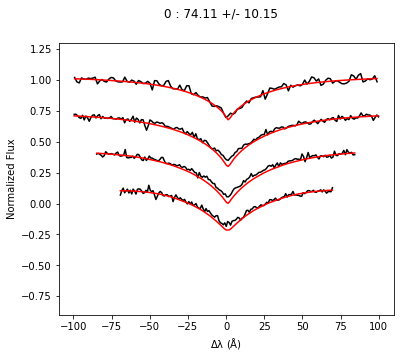

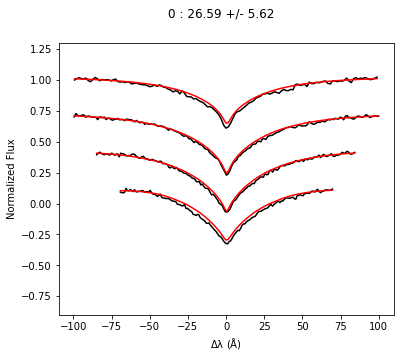

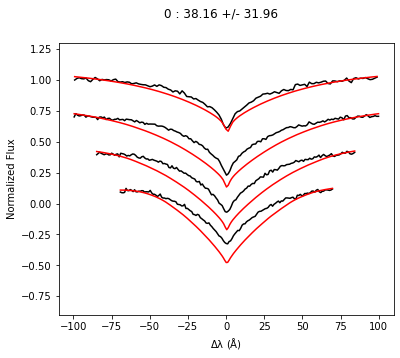

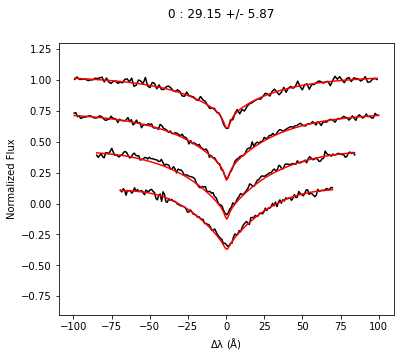

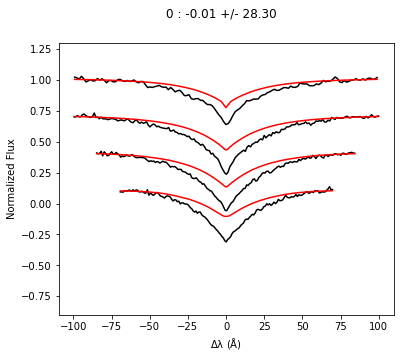

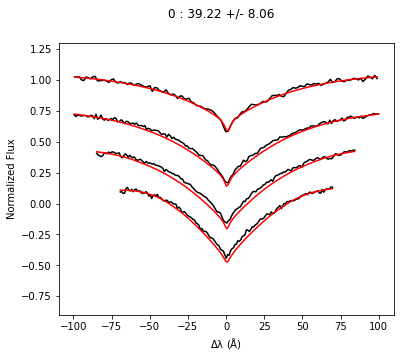

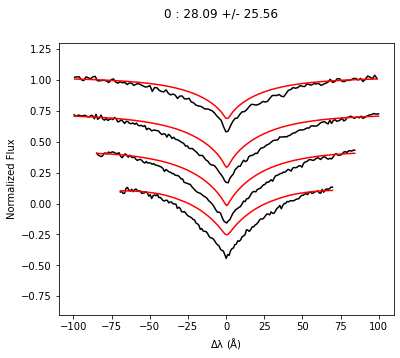

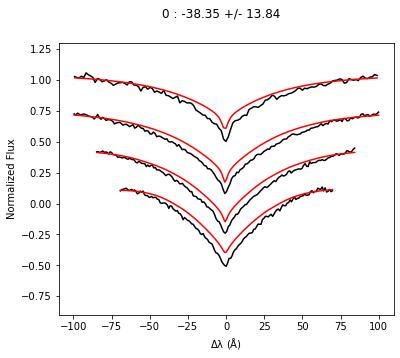

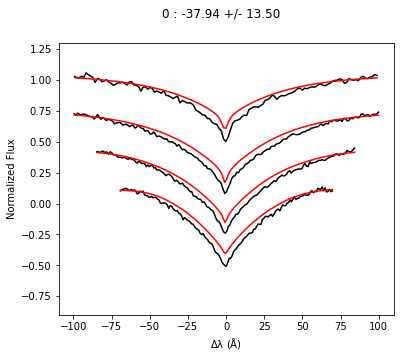

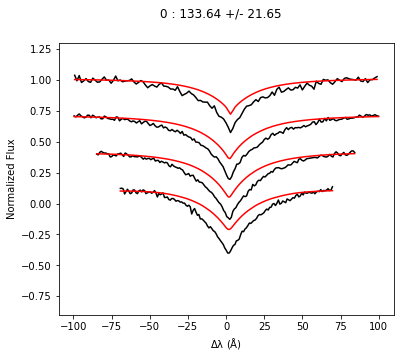

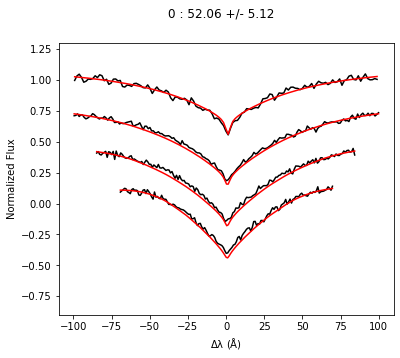

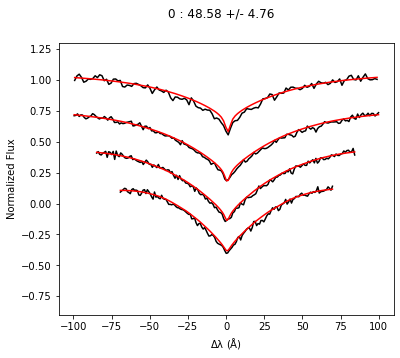

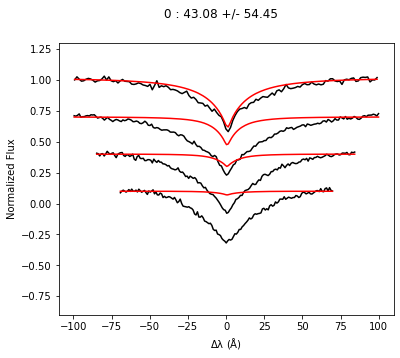

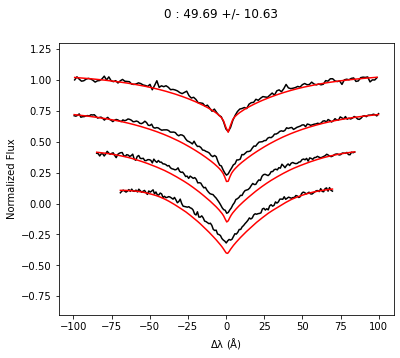

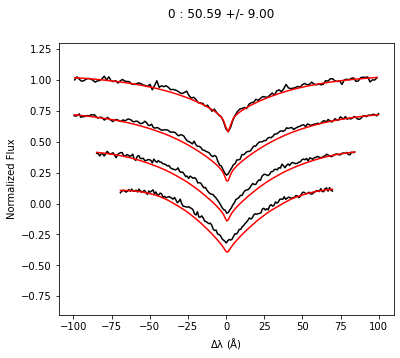

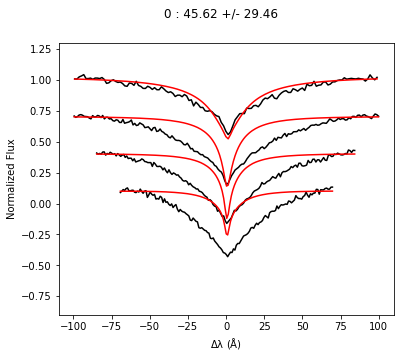

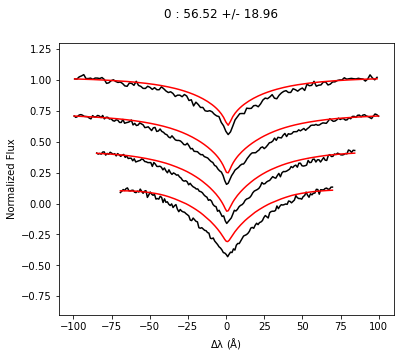

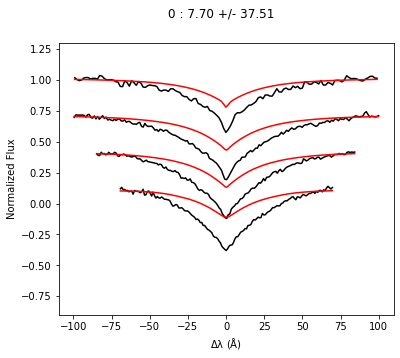

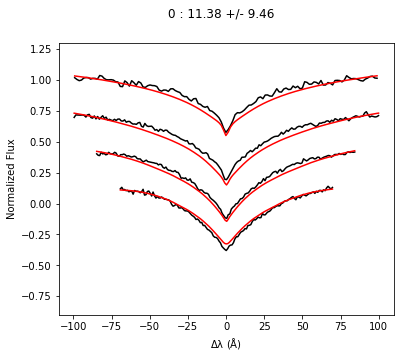

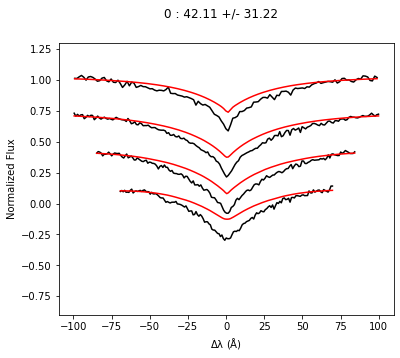

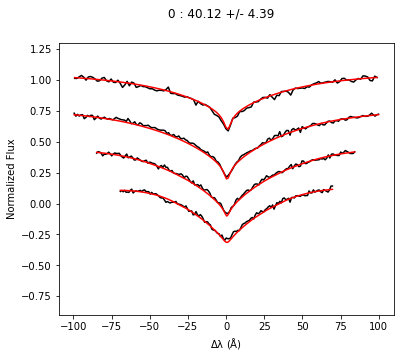

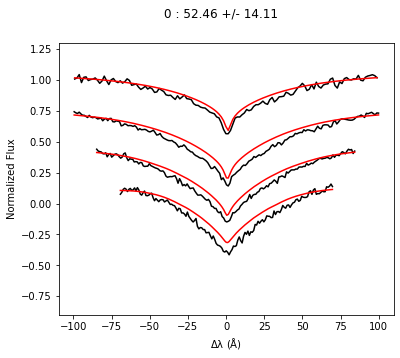

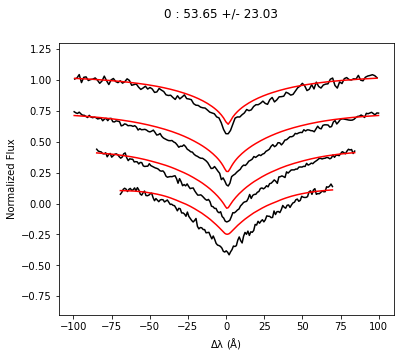

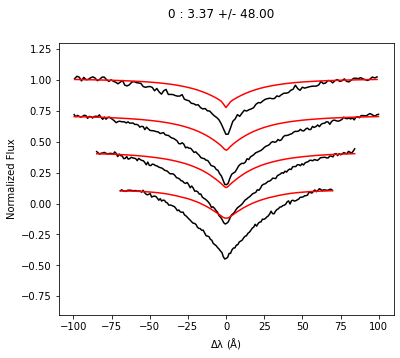

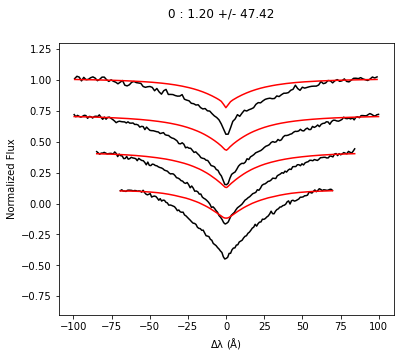

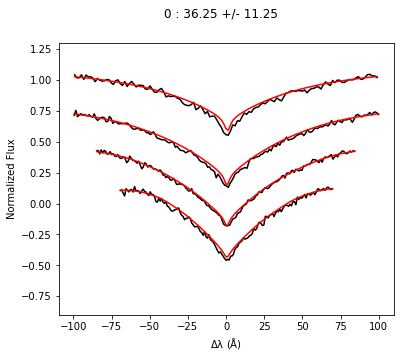

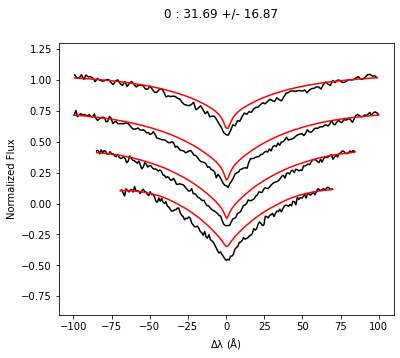

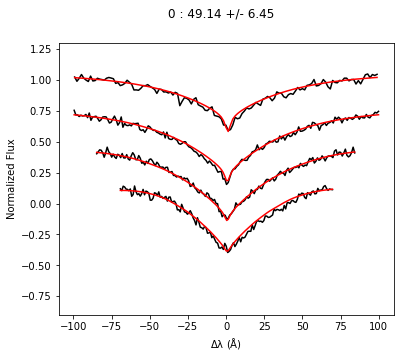

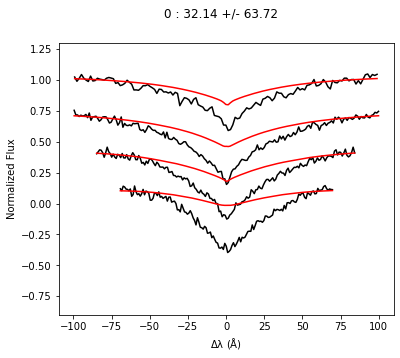

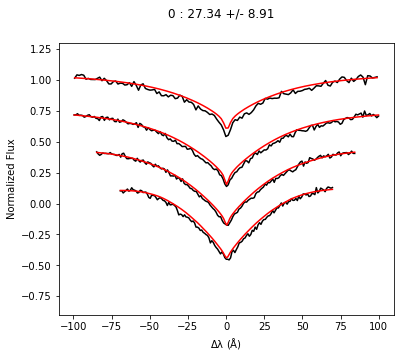

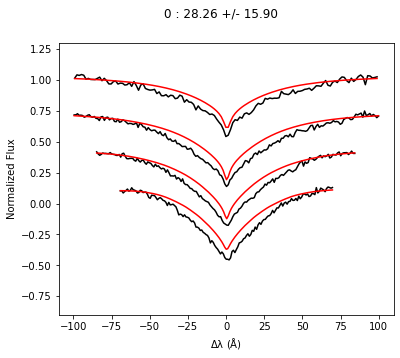

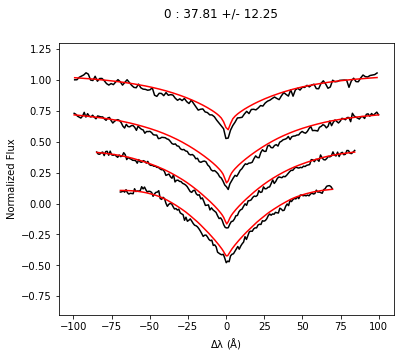

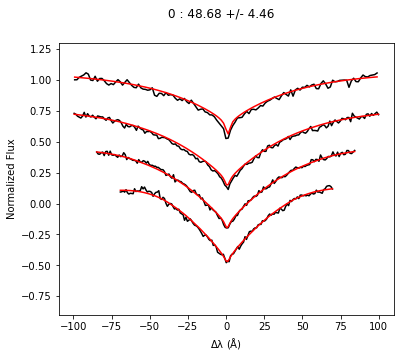

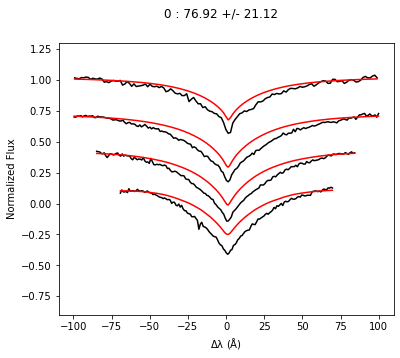

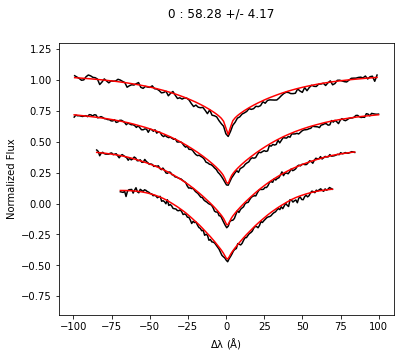

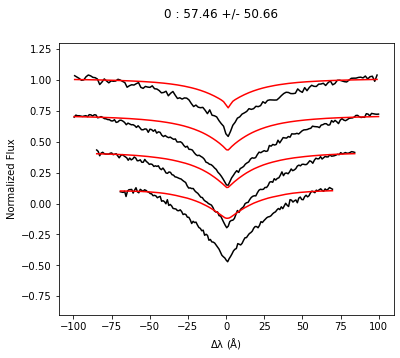

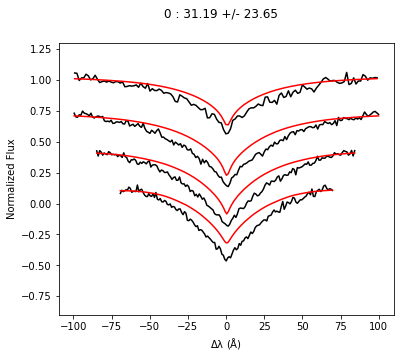

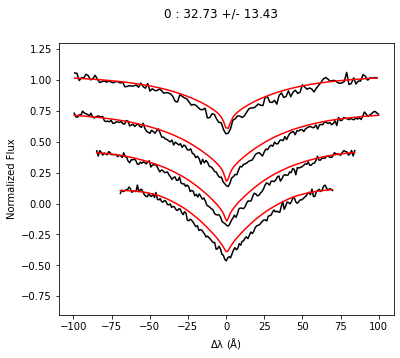

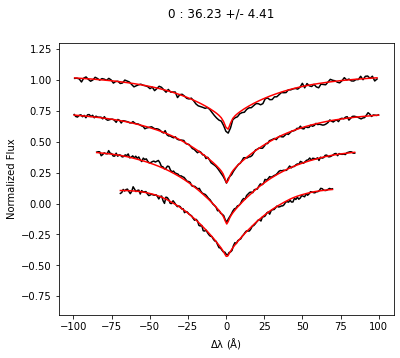

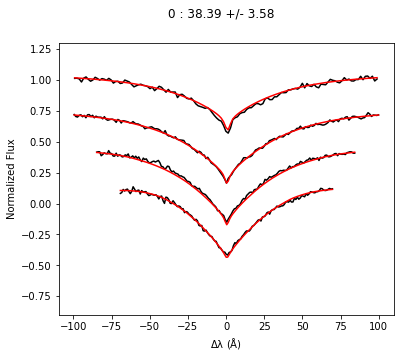

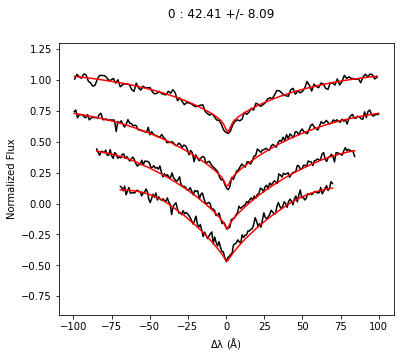

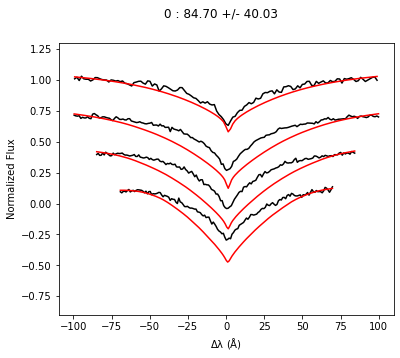

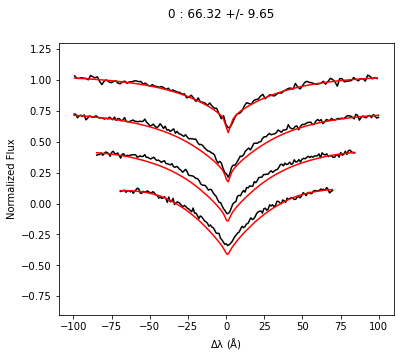

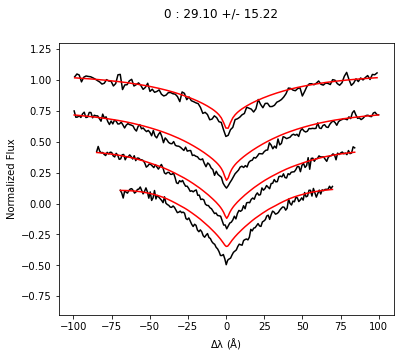

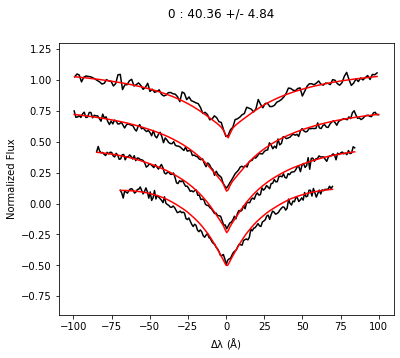

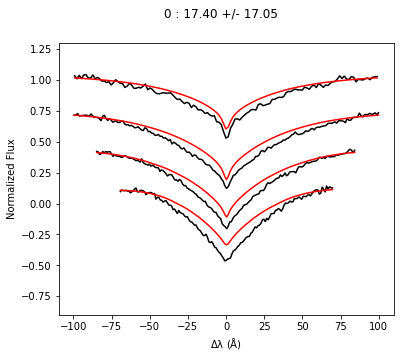

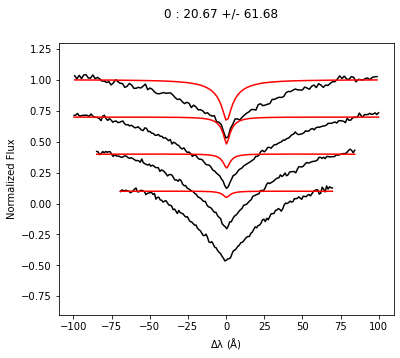

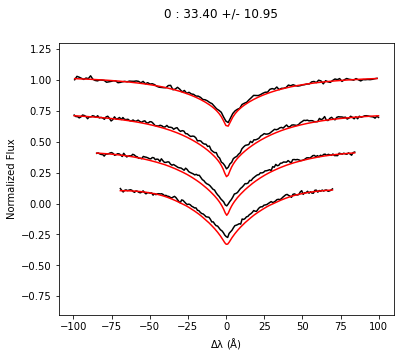

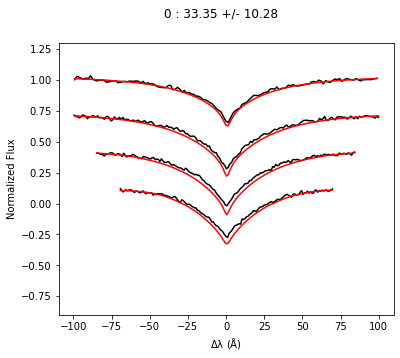

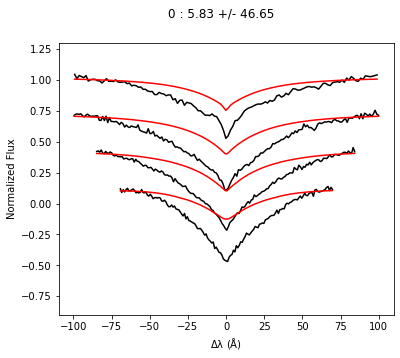

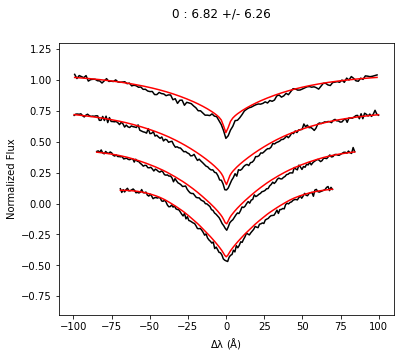

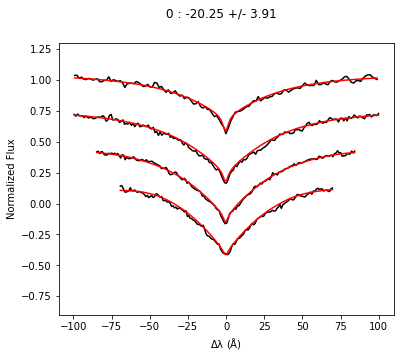

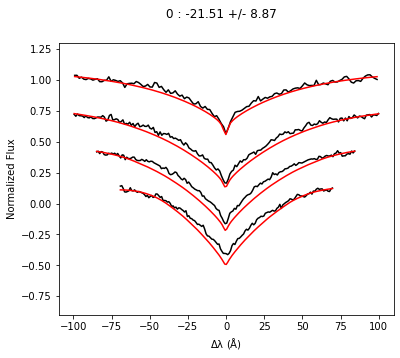

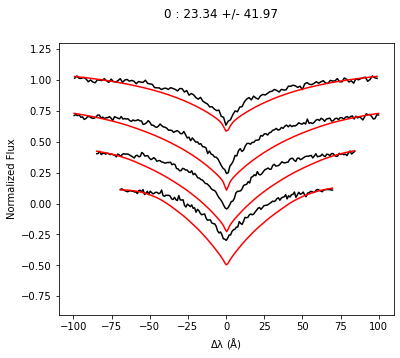

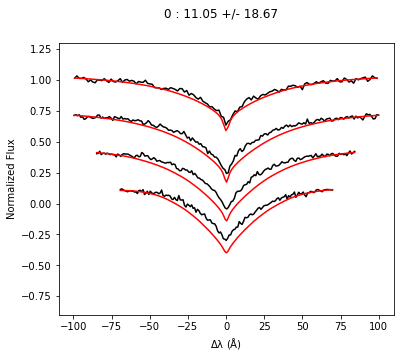

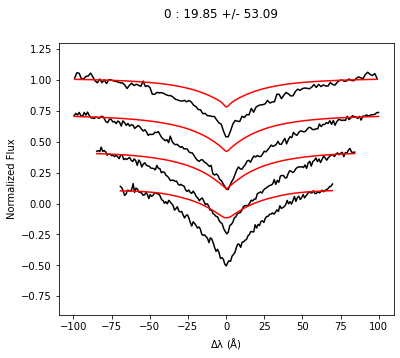

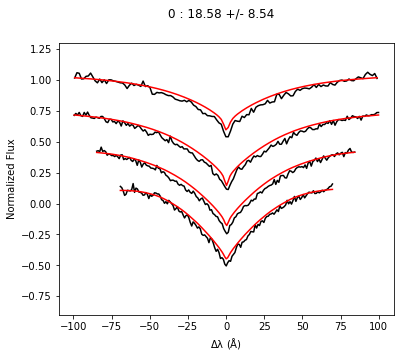

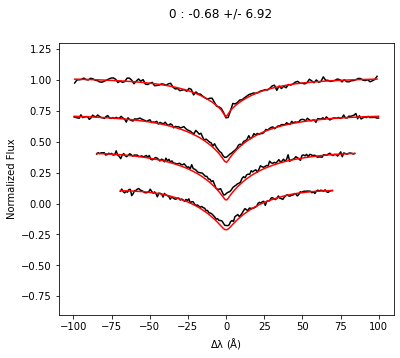

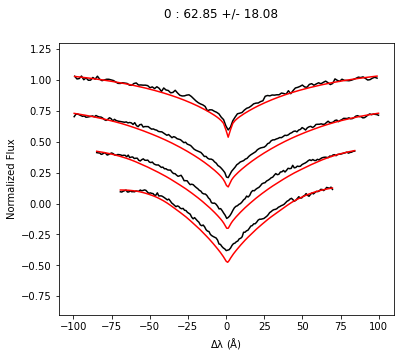

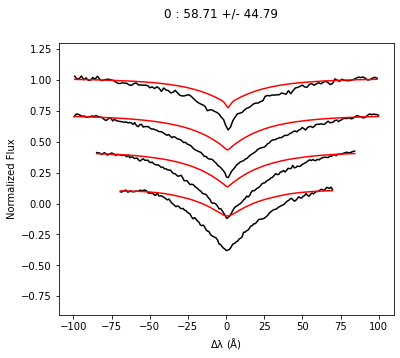

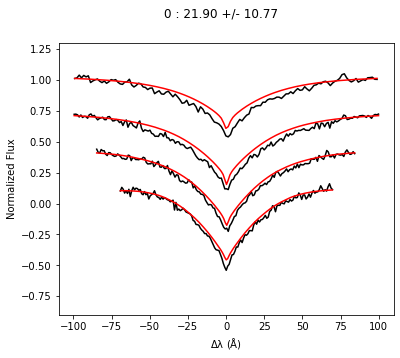

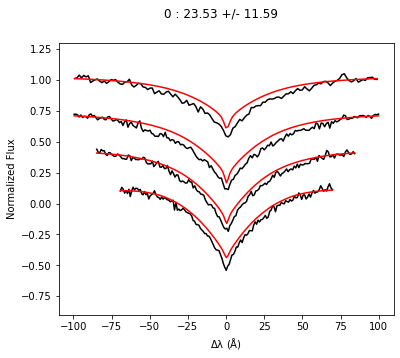

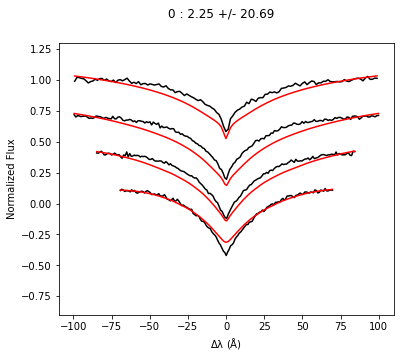

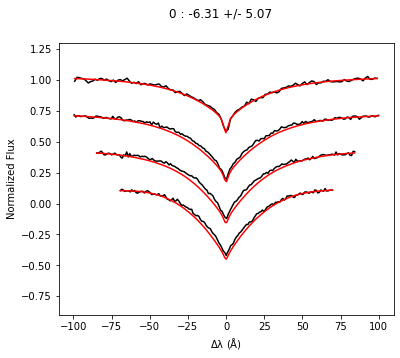

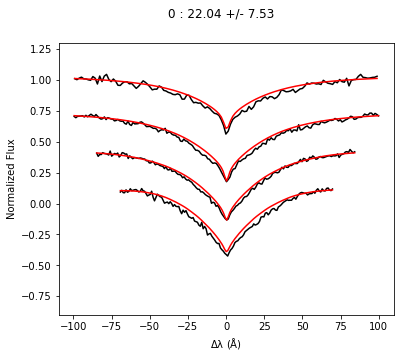

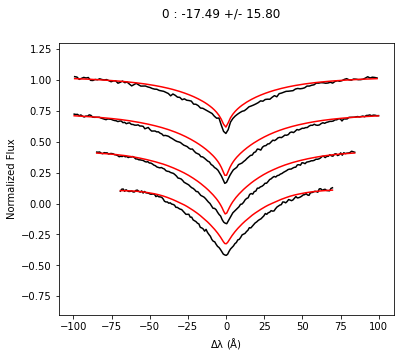

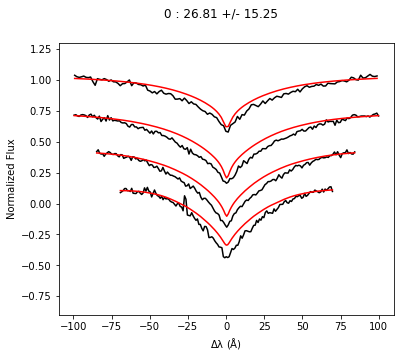

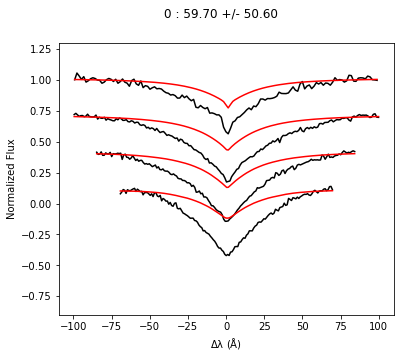

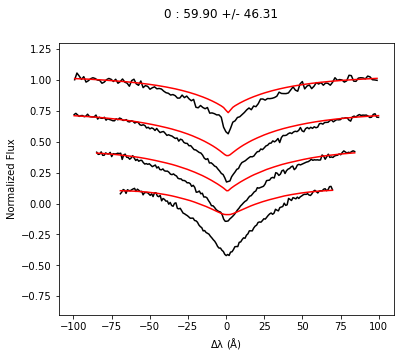

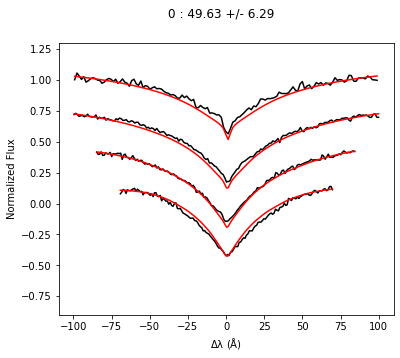

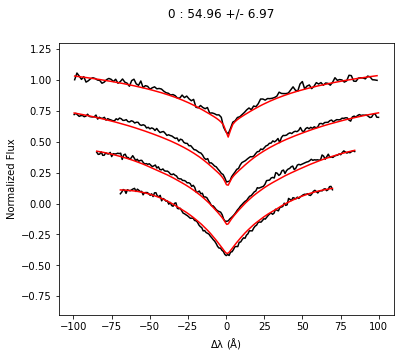

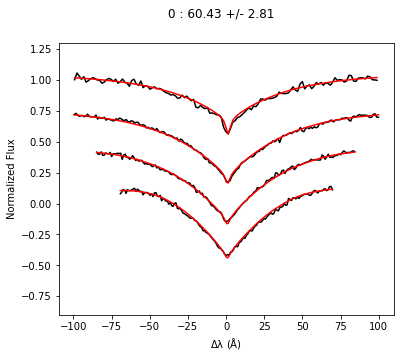

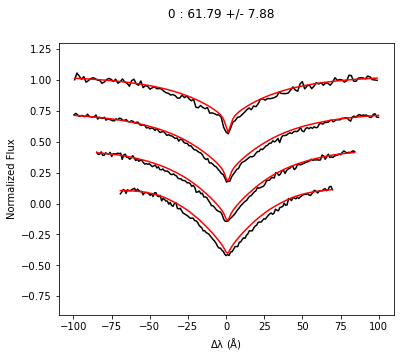

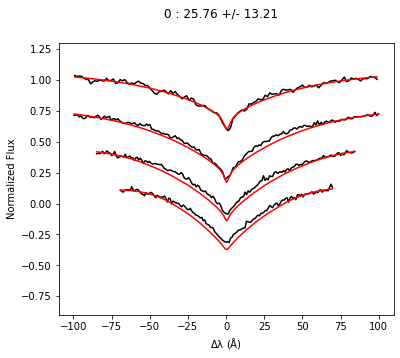

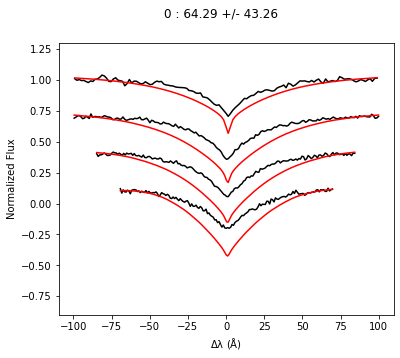

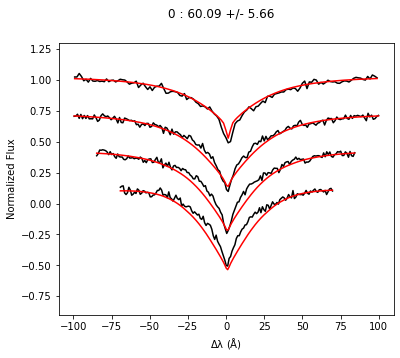

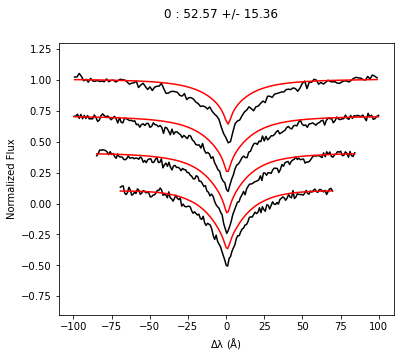

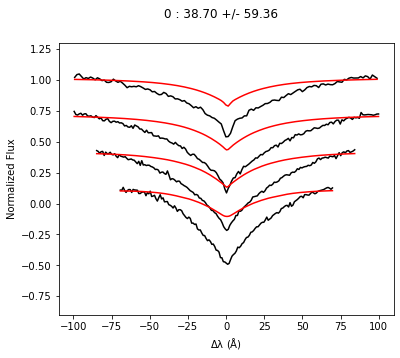

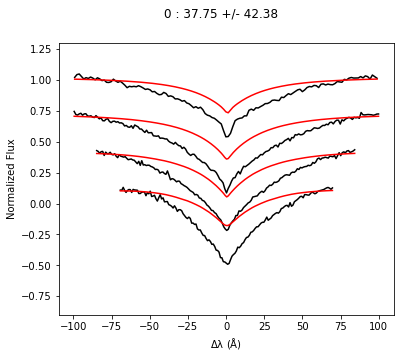

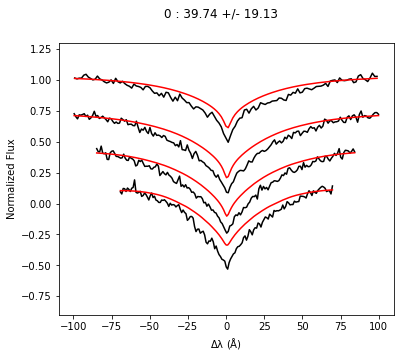

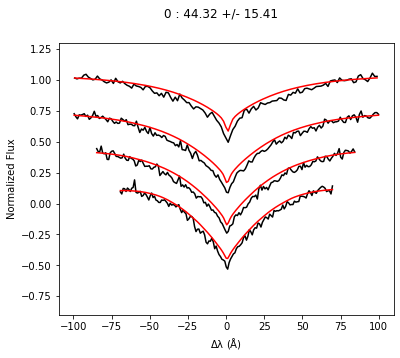

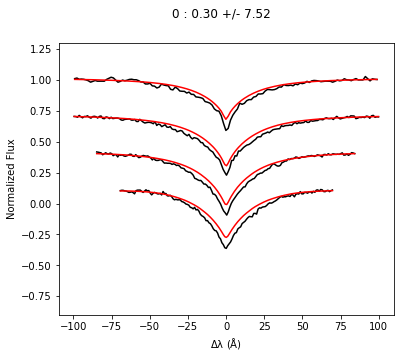

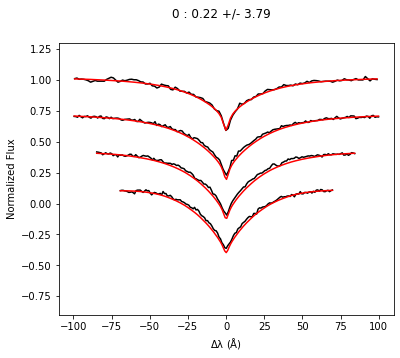

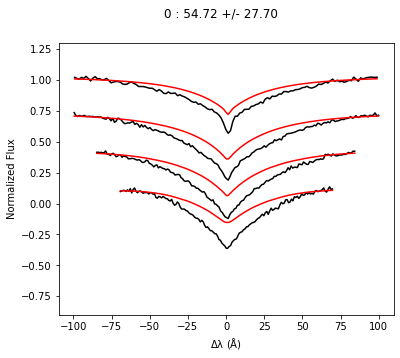

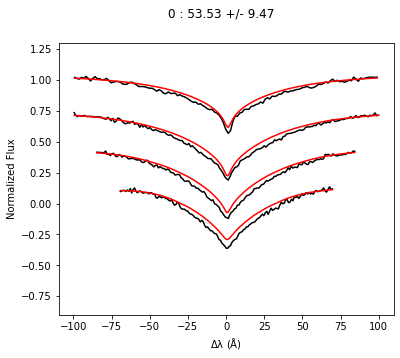

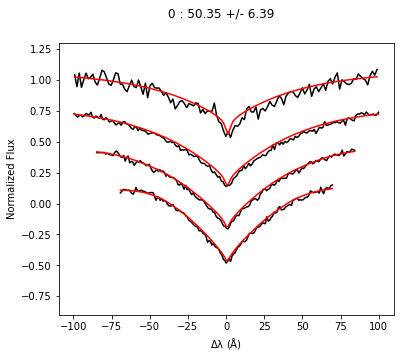

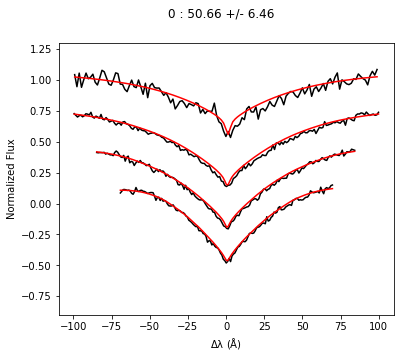

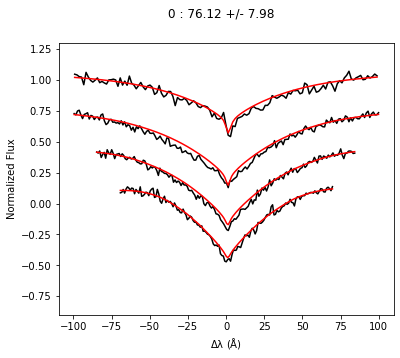

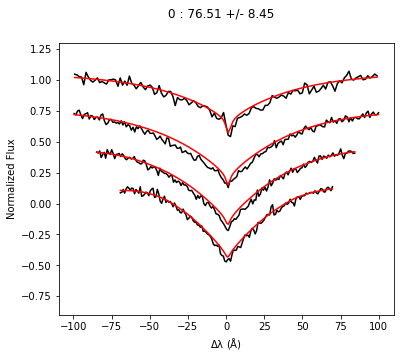

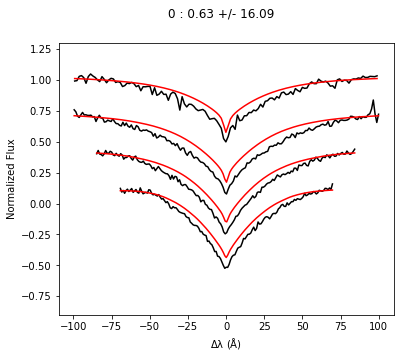

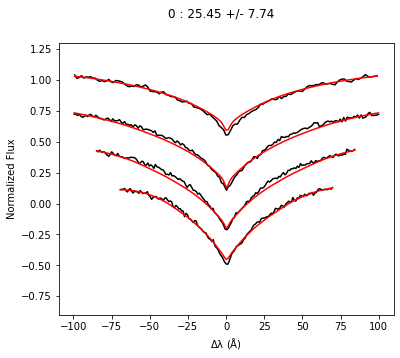

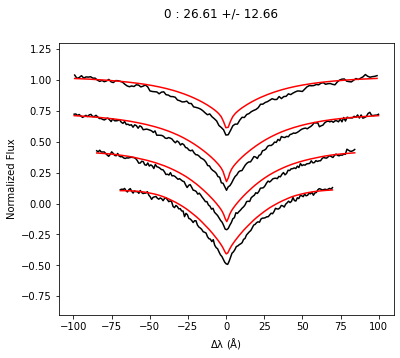

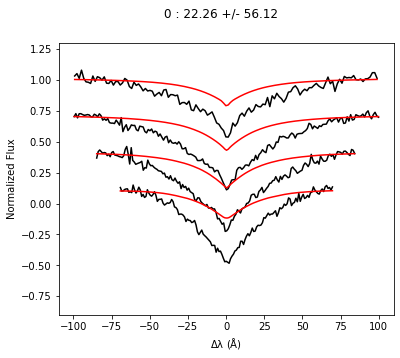

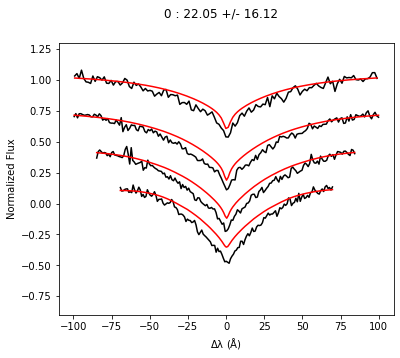

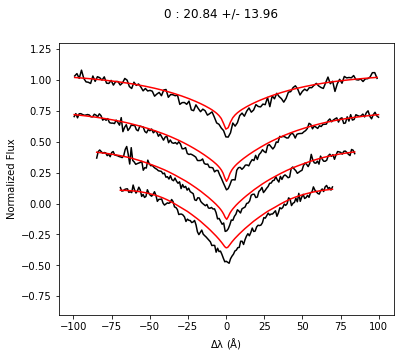

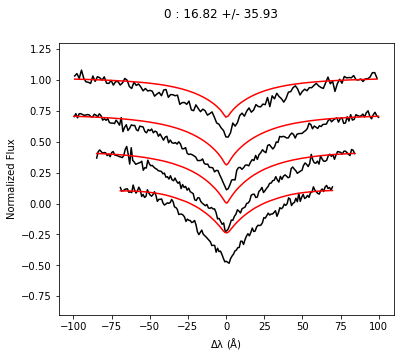

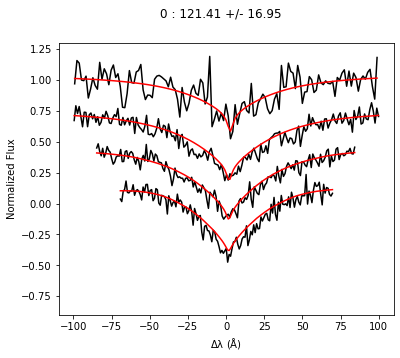

In [13]:
figs = []

for j in tqdm( range(len(falcon_xmatch))):
    p,m,f = np.array(falcon_xmatch['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    if xid == None:
        print('object not found in SDSS... skipping...')
        continue
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
        
        print(catalog['teff'][j])
        
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel, teff = catalog['teff'][j])
        print(str(rv_res.params['RV'].value) + '+/-' + str(rv_res.params['RV'].stderr))
        
        f = corv.utils.lineplot(wl, fl, ivar, corvmodel, rv_res.params, gap = 0.3, printparams = False, figsize = (6, 5))

        f.suptitle('%d : %2.2f +/- %2.2f' % (i, rv_res.params['RV'].value, rv_res.params['RV'].stderr))
        figs.append(f)
        
        
        
    falcon_xmatch['corv_rv'][j] = (rv_res.params['RV'].value)
    falcon_xmatch['corv_erv'][j] = (rv_res.params['RV'].stderr)
    


In [14]:
for i in range(len(figs)):
    figs[i].savefig('fits/corvfit{}.jpg'.format(i))

In [15]:
print(falcon_xmatch['corv_erv'])

     corv_erv     
------------------
10.145891627211274
 5.618525354128895
 31.96286369630652
 5.866281747310028
28.297768574919257
  8.06146562012801
25.561208306837422
13.843830425961578
13.497370975748328
21.649441342072834
               ...
 6.455337648254684
   7.9758661104323
 8.446213210569525
16.089038233180872
  7.73755562624293
12.664004661031358
 56.11536684654997
16.122121041930733
13.962013686986035
 35.93490486482228
 16.95039798288878
Length = 97 rows


In [16]:
falcon_xmatch.write('./falcon.fits', overwrite = True)

In [4]:
from astropy.table import Table

falcon_xmatch = Table.read('falcon.fits')

97


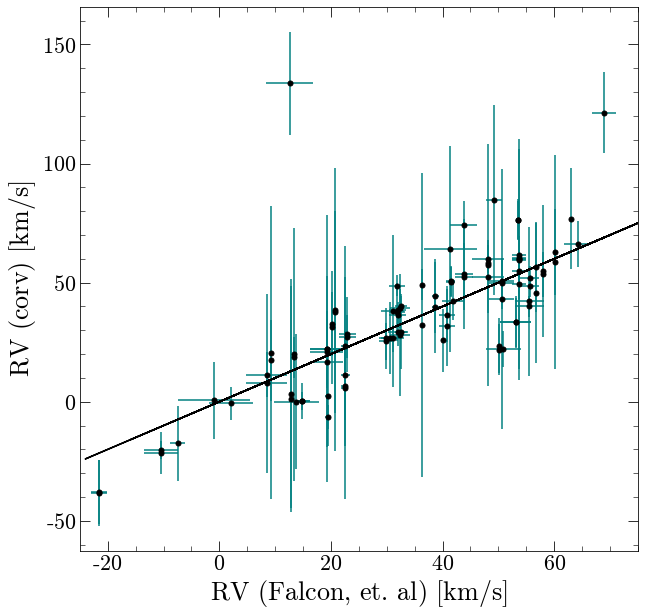

In [13]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def linear(x):
    return x

#temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.style.use('../stefan.mplstyle')

print(len(falcon_xmatch))


plt.errorbar(falcon_xmatch['Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], falcon_xmatch['corv_rv'][np.abs(falcon_xmatch['corv_rv']) < 2500], 
             xerr = falcon_xmatch['e_Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], yerr = falcon_xmatch['corv_erv'][np.abs(falcon_xmatch['corv_rv']) < 2500],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500], linear(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500]), color = 'black')


ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Falcon, et. al) $[km/s]$')
plt.ylabel(r'RV (corv) $[km/s]$')

plt.xlim(-25, 75)


plt.savefig('corv_validation.pdf')

## Sirius Validation
Sirius B
* Right ascension: 06h 45m 09.0s
* Declination: −16° 43′ 06″RightRight

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

siriusa = SkyCoord('06 45 08.917 −16 42 58.02',  unit=(u.hourangle, u.deg), frame='icrs') 
siriusb = SkyCoord('06 45 09 -16 43 06',  unit=(u.hourangle, u.deg), frame='icrs')

sirius = Table([['sirius_a', 'sirius_b'], [siriusa.ra.deg, siriusb.ra.deg], [siriusa.dec.deg, siriusb.dec.deg],[siriusa, siriusb]], names=('star', 'ra', 'dec', 'skycoord'))
print(sirius)

radius = u.Quantity(30.0, u.arcmin)

In [ ]:
print(siriusa.ra, siriusa.dec)
print(siriusb.ra, siriusb.dec)

result = Gaia.query_object(siriusa, radius = radius)
print(len(result))

In [ ]:
result['skycoord'] = SkyCoord(result['ra'], result['dec'], unit=(u.deg, u.deg))
#catalog = join(result, sirius, keys='ra', join_type='inner')

In [ ]:
plt.scatter(result['ra'], result['dec'], s=15, c=result['parallax'])
plt.vlines(sirius['ra'], ymin=-16.74, ymax=-16.69, alpha=0.8) 
plt.hlines(sirius['dec'], xmin=101.26, xmax=101.31, alpha=0.8) 
plt.colorbar()

In [ ]:
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

j1 = Gaia.cone_search_async(siriusa, radius)
#j2 = Gaia.cone_search_async(siriusb, radius)

In [ ]:
sirius_a_gaia = j1.get_results()[0]
#sirius_b_gaia = j2.get_results()[0]

In [ ]:
#print(sirius_a_gaia['solution_id'] == sirius_b_gaia['solution_id'])
print(sirius_a_gaia['phot_g_mean_mag'])